# ESE538 Complete Time Series Forecasting Baseline

## 🎯 Model Coverage

### Classical Statistical Methods

1. **Seasonal Naive** - Baseline (P=7)

2. **ETS** - Exponential Smoothing

3. **SARIMAX** - Seasonal ARIMA with exogenous variables

### Tree-Based Gradient Boosting

4. **LightGBM** - Quantile regression + CV tuning

5. **XGBoost** - Industry standard

6. **CatBoost** - Categorical feature specialist

### Deep Learning

7. **TCN** - Temporal Convolutional Network

## 📊 Evaluation Framework

- **Point Prediction**: RMSE, MAE, sMAPE, MASE

- **Probability Prediction**: Pinball Loss, Coverage, CRPS

- **Statistical Tests**: Diebold-Mariano test

- **Feature Engineering**: 100+ features With ablation support - **Cross-validation**: Time-series rolling-origin

In [1]:
%%capture
!pip install -U pip
!pip install --force-reinstall --no-cache-dir -q "urllib3<2.0" kaggle==1.6.17 pandas==2.2.2 numpy==1.26.4 matplotlib==3.8.4 seaborn==0.13.2 lightgbm==4.3.0 scikit-learn==1.5.2 statsmodels==0.14.2 catboost==1.2.5 xgboost==2.1.1 rich==13.7.1 tqdm==4.66.5
!pip install optuna

In [ ]:
# Restart runtime after installation
import os
os.kill(os.getpid(), 9)

In [1]:
# ============================================================================

from pathlib import Path
import os

try:
    from google.colab import files
except ImportError:
    files = None

DATA_ROOT = Path("data/raw")
DATA_ROOT.mkdir(parents=True, exist_ok=True)
kaggle_token_path = Path("~/.kaggle/kaggle.json").expanduser()

if files is not None and not kaggle_token_path.exists():
    print("Upload kaggle.json")
    uploaded = files.upload()
    if "kaggle.json" not in uploaded:
        raise RuntimeError("kaggle.json not found")
    kaggle_token_path.parent.mkdir(parents=True, exist_ok=True)
    kaggle_token_path.write_bytes(uploaded["kaggle.json"])
    os.chmod(kaggle_token_path, 0o600)
elif kaggle_token_path.exists():
    print("✅ kaggle.json found")

zip_path = DATA_ROOT / "store-sales-time-series-forecasting.zip"
if not (DATA_ROOT / "train.csv").exists():
    !kaggle competitions download -c store-sales-time-series-forecasting -p {DATA_ROOT} --force
    !unzip -o {zip_path} -d {DATA_ROOT}
else:
    print("✅ Data exists")

# ============================================================================

Upload kaggle.json


Saving kaggle.json to kaggle.json
100% 21.4M/21.4M [00:02<00:00, 20.5MB/s]
100% 21.4M/21.4M [00:02<00:00, 11.0MB/s]
Archive:  data/raw/store-sales-time-series-forecasting.zip
  inflating: data/raw/holidays_events.csv  
  inflating: data/raw/oil.csv        
  inflating: data/raw/sample_submission.csv  
  inflating: data/raw/stores.csv     
  inflating: data/raw/test.csv       
  inflating: data/raw/train.csv      
  inflating: data/raw/transactions.csv  


In [2]:
# ============================================================================

import json
import math
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from rich import print as rprint

import lightgbm as lgb
from catboost import CatBoostRegressor
import xgboost as xgb

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_pinball_loss
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 120)

SEED = 4380
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

rprint(f"[bold cyan]Device: {DEVICE}[/bold cyan]")

# ============================================================================

Device: cuda

In [3]:
# ============================================================================

BASE_PATH = Path("data/raw")
HORIZONS = [7, 14, 28]
TARGET_STORES = [1, 2, 3, 4]
TARGET_FAMILIES = ["GROCERY I", "BEVERAGES", "DAIRY", "BREAD/BAKERY", "MEAT"]
TRAIN_CUTOFF = pd.Timestamp("2016-12-31")
VAL_CUTOFF = pd.Timestamp("2017-04-30")
SEASONAL_PERIOD = 7
INPUT_WINDOW = 56

FEATURE_FLAGS = {
    "store_level": True,
    "cluster_level": True,
    "family_level": True,
    "lag_interactions": True,
    "holiday_windows": True,
}

LIGHTGBM_BASE_PARAMS = {
    "objective": "quantile",
    "learning_rate": 0.025,
    "num_leaves": 64,
    "feature_fraction": 0.75,
    "bagging_fraction": 0.7,
    "bagging_freq": 1,
    "min_data_in_leaf": 96,
    "verbosity": -1,
}

rprint("[green]✓ Config loaded[/green]")

# ============================================================================

✓ Config loaded

In [4]:
# ============================================================================

def rmse(y_true, y_pred):
    """Root Mean Squared Error"""
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


def smape(y_true, y_pred, eps: float = 1e-8):
    """Symmetric Mean Absolute Percentage Error"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred) + eps) / 2.0
    return np.mean(np.abs(y_pred - y_true) / denom) * 100.0


def mase(y_true, y_pred, y_train, m: int = 7):
    """
    Mean Absolute Scaled Error

    MASE < 1
    MASE = 1
    MASE > 1
    """
    y_train = np.asarray(y_train)
    if len(y_train) <= m:
        return np.nan
    denom = np.mean(np.abs(y_train[m:] - y_train[:-m]))
    if denom == 0:
        return np.nan
    return np.mean(np.abs(y_true - y_pred)) / denom


def pinball_loss(y_true, q_pred, alpha):
    """Pinball Loss for quantile regression"""
    y_true = np.asarray(y_true)
    q_pred = np.asarray(q_pred)
    diff = y_true - q_pred
    return np.mean(np.maximum(alpha * diff, (alpha - 1) * diff))


def coverage(y_true, q_low, q_high):
    """Prediction interval coverage"""
    y_true = np.asarray(y_true)
    return np.mean((y_true >= q_low) & (y_true <= q_high))


def crps_from_quantiles(y_true, q10, q50, q90):
    """
    Continuous Ranked Probability Score
    """
    alphas = [0.1, 0.5, 0.9]
    preds = [q10, q50, q90]
    return float(np.mean([pinball_loss(y_true, preds[i], alphas[i]) for i in range(3)]))


def diebold_mariano(e1, e2, h: int = 1):
    """
    Diebold-Mariano

    Returns:
        (DM_stat, p_value)
        - DM > 0
        - DM < 0
        - p < 0.05
    """
    e1 = np.asarray(e1)
    e2 = np.asarray(e2)
    d = e1**2 - e2**2
    d_bar = d.mean()

    # Newey-West HAC variance
    L = max(1, h - 1)
    gamma0 = np.var(d, ddof=1)
    cov = gamma0
    n = len(d)

    for lag in range(1, min(L, n - 1) + 1):
        gamma = np.cov(d[:-lag], d[lag:])[0, 1]
        cov += 2 * (1 - lag / (L + 1)) * gamma

    var_dbar = cov / n
    if var_dbar <= 0:
        return np.nan, np.nan

    DM = d_bar / math.sqrt(var_dbar)
    p_value = 2 * (1 - norm.cdf(abs(DM)))
    return float(DM), float(p_value)


rprint("[green]✓ Metrics functions loaded[/green]")

# ============================================================================

✓ Metrics functions loaded

In [5]:
# ============================================================================

def load_kaggle_tables(base_path: Path) -> Dict[str, pd.DataFrame]:
    """Load all Kaggle tables"""
    tables = {
        "train": pd.read_csv(base_path / "train.csv", parse_dates=["date"]),
        "stores": pd.read_csv(base_path / "stores.csv"),
        "oil": pd.read_csv(base_path / "oil.csv", parse_dates=["date"]),
        "transactions": pd.read_csv(base_path / "transactions.csv", parse_dates=["date"]),
        "holidays_events": pd.read_csv(base_path / "holidays_events.csv", parse_dates=["date"]),
    }
    return tables


def attach_holiday_features(df: pd.DataFrame, holidays: pd.DataFrame) -> pd.DataFrame:
    """Attach holiday features"""
    holidays = holidays.copy()
    holidays["transferred"] = holidays["transferred"].fillna(False)
    holidays = holidays[~holidays["transferred"]]
    holidays = holidays[holidays["type"] != "Work Day"]
    holidays["locale_name"] = holidays["locale_name"].str.strip()

    national = (
        holidays[holidays["locale"] == "National"]["date"].drop_duplicates().to_frame()
        .assign(is_national_holiday=1)
    )
    df = df.merge(national, on="date", how="left")

    regional = (
        holidays[holidays["locale"] == "Regional"][["date", "locale_name"]]
        .drop_duplicates()
        .rename(columns={"locale_name": "state"})
        .assign(is_regional_holiday=1)
    )
    df = df.merge(regional, on=["date", "state"], how="left")

    local = (
        holidays[holidays["locale"] == "Local"][["date", "locale_name"]]
        .drop_duplicates()
        .rename(columns={"locale_name": "city"})
        .assign(is_local_holiday=1)
    )
    df = df.merge(local, on=["date", "city"], how="left")

    for col in ["is_national_holiday", "is_regional_holiday", "is_local_holiday"]:
        df[col] = df[col].fillna(0).astype(int)

    return df


rprint("[green]✓ Data loading functions ready[/green]")

✓ Data loading functions ready

In [6]:
# ============================================================================

def prepare_feature_panel(
    tables: Dict[str, pd.DataFrame],
    target_stores: List[int],
    target_families: List[str],
    horizons: List[int],
    seasonal_period: int,
) -> Tuple[pd.DataFrame, pd.DataFrame, List[str], List[str], List[str]]:
    """
    Complete feature engineering pipeline
    """
    train = tables["train"].copy()
    stores = tables["stores"].copy()
    oil = tables["oil"].copy()
    transactions = tables["transactions"].copy()
    holidays = tables["holidays_events"].copy()

    # Merge
    df = (
        train.merge(stores, on="store_nbr", how="left")
        .query("store_nbr in @target_stores")
        .copy()
    )
    if target_families:
        df = df[df["family"].isin(target_families)].copy()

    df.sort_values(["store_nbr", "family", "date"], inplace=True)
    df["onpromotion"] = df["onpromotion"].fillna(0)

    # Transactions
    transactions = transactions.rename(columns={"transactions": "store_transactions"})
    df = df.merge(transactions, on=["date", "store_nbr"], how="left")
    df["store_transactions"] = df["store_transactions"].fillna(0)

    # Oil price
    oil["dcoilwtico"] = oil["dcoilwtico"].interpolate(limit_direction="both")
    df = df.merge(oil, on="date", how="left")
    df["dcoilwtico"] = df["dcoilwtico"].interpolate(limit_direction="both")

    # Holidays
    df = attach_holiday_features(df, holidays)

    # Holiday windows
    if FEATURE_FLAGS.get("holiday_windows", True):
        df["any_holiday"] = df[["is_national_holiday", "is_regional_holiday", "is_local_holiday"]].max(axis=1)

        def _distance_to_holiday(frame, group_key, indicator_col, prefix):
            event_dates = frame["date"].where(frame[indicator_col] == 1)
            last_holiday = event_dates.groupby(frame[group_key]).ffill()
            next_holiday = event_dates.groupby(frame[group_key]).bfill()
            frame[f"days_since_{prefix}_holiday"] = (
                (frame["date"] - last_holiday).dt.days.astype("float64").fillna(999).astype(int)
            )
            frame[f"days_to_{prefix}_holiday"] = (
                (next_holiday - frame["date"]).dt.days.astype("float64").fillna(999).astype(int)
            )

        _distance_to_holiday(df, "store_nbr", "any_holiday", "any")
        _distance_to_holiday(df, "store_nbr", "is_national_holiday", "national")
        df["is_holiday_next_7d"] = (df.get("days_to_any_holiday", 999) <= 7).astype(int)
        df["is_post_holiday_7d"] = (df.get("days_since_any_holiday", 999) <= 7).astype(int)

    df["dayofweek"] = df["date"].dt.dayofweek
    df["weekofyear"] = df["date"].dt.isocalendar().week.astype(int)
    df["month"] = df["date"].dt.month
    df["dayofmonth"] = df["date"].dt.day
    df["year"] = df["date"].dt.year
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)
    df["month_progress"] = df["dayofmonth"] / df["date"].dt.days_in_month

    # Fourier features
    df["fourier_week_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["fourier_week_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["fourier_biweek_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 14)
    df["fourier_biweek_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 14)
    df["fourier_quarter_sin"] = np.sin(2 * np.pi * df["date"].dt.dayofyear / 91.25)
    df["fourier_quarter_cos"] = np.cos(2 * np.pi * df["date"].dt.dayofyear / 91.25)
    df["fourier_year_sin"] = np.sin(2 * np.pi * df["date"].dt.dayofyear / 365.25)
    df["fourier_year_cos"] = np.cos(2 * np.pi * df["date"].dt.dayofyear / 365.25)

    # Store-level features
    df["store_daily_sales"] = df.groupby(["date", "store_nbr"])["sales"].transform("sum")
    df["store_sales_rank_pct"] = df.groupby(["date", "store_nbr"])["sales"].rank(pct=True)

    if FEATURE_FLAGS.get("store_level", True):
        df["store_rolling_sales_7"] = df.groupby("store_nbr")["store_daily_sales"].transform(
            lambda s: s.shift(1).rolling(window=7, min_periods=1).mean()
        )
        df["store_rolling_sales_28"] = df.groupby("store_nbr")["store_daily_sales"].transform(
            lambda s: s.shift(1).rolling(window=28, min_periods=1).mean()
        )
        df["store_sales_share"] = df["sales"] / (df["store_daily_sales"] + 1e-3)

    # Family-level features
    if FEATURE_FLAGS.get("family_level", True):
        df["family_daily_sales"] = df.groupby(["date", "family"])["sales"].transform("sum")
        df["family_sales_share"] = df["sales"] / (df["family_daily_sales"] + 1e-3)

        for window in [7, 14, 28]:
            roll = df.groupby("family")["sales"].transform(
                lambda s, w=window: s.shift(1).rolling(window=w, min_periods=1).mean()
            )
            df[f"family_roll_mean_{window}"] = roll

    # Lag features
    group_cols = ["store_nbr", "family"]
    lag_list = [1, 7, 14, 28, 56]
    for lag in lag_list:
        df[f"lag_sales_{lag}"] = df.groupby(group_cols)["sales"].shift(lag)
        df[f"lag_onpromo_{lag}"] = df.groupby(group_cols)["onpromotion"].shift(lag)
        df[f"lag_transactions_{lag}"] = df.groupby(group_cols)["store_transactions"].shift(lag)

    # Diff features
    diff_lags = [1, 7, 14]
    for lag in diff_lags:
        df[f"diff_sales_{lag}"] = df.groupby(group_cols)["sales"].diff(lag)
        df[f"diff_onpromo_{lag}"] = df.groupby(group_cols)["onpromotion"].diff(lag)

    # Rolling features
    windows = [7, 14, 28, 56]
    for window in windows:
        df[f"roll_mean_sales_{window}"] = df.groupby(group_cols)["sales"].transform(
            lambda s: s.shift(1).rolling(window=window, min_periods=1).mean()
        )
        df[f"roll_std_sales_{window}"] = df.groupby(group_cols)["sales"].transform(
            lambda s: s.shift(1).rolling(window=window, min_periods=1).std()
        )
        df[f"roll_median_sales_{window}"] = df.groupby(group_cols)["sales"].transform(
            lambda s: s.shift(1).rolling(window=window, min_periods=1).median()
        )
        df[f"roll_max_sales_{window}"] = df.groupby(group_cols)["sales"].transform(
            lambda s: s.shift(1).rolling(window=window, min_periods=1).max()
        )
        df[f"roll_min_sales_{window}"] = df.groupby(group_cols)["sales"].transform(
            lambda s: s.shift(1).rolling(window=window, min_periods=1).min()
        )
        df[f"roll_cv_sales_{window}"] = df[f"roll_std_sales_{window}"] / (
            df[f"roll_mean_sales_{window}"] + 1e-3
        )

    # Lag interactions
    if FEATURE_FLAGS.get("lag_interactions", True):
        df["lag_diff_7_14"] = df["lag_sales_7"] - df["lag_sales_14"]
        df["lag_diff_14_28"] = df["lag_sales_14"] - df["lag_sales_28"]
        df["lag_ratio_7_28"] = df["lag_sales_7"] / (df["lag_sales_28"] + 1e-3)

    # Promo features
    df["promo_rolling_7"] = df.groupby(group_cols)["onpromotion"].transform(
        lambda s: s.shift(1).rolling(window=7, min_periods=1).mean()
    ).fillna(0)
    df["promo_rolling_28"] = df.groupby(group_cols)["onpromotion"].transform(
        lambda s: s.shift(1).rolling(window=28, min_periods=1).mean()
    ).fillna(0)

    # Additional features
    df["log_sales_plus1"] = np.log1p(df["sales"])
    df["log_transactions_plus1"] = np.log1p(df["store_transactions"])
    df["sales_per_transaction"] = np.where(
        df["store_transactions"] > 0, df["sales"] / df["store_transactions"], 0.0
    )
    df["sales_per_promo"] = np.where(df["onpromotion"] > 0, df["sales"] / df["onpromotion"], 0.0)

    # Target variables for each horizon
    target_cols = []
    snaive_cols = []
    for h in horizons:
        target_col = f"target_tplus_{h}"
        snaive_col = f"snaive_pred_h{h}"
        df[target_col] = df.groupby(group_cols)["sales"].shift(-h)

        # Seasonal naive prediction
        offset = h - seasonal_period
        if offset == 0:
            df[snaive_col] = df.groupby(group_cols)["sales"].shift(0)
        else:
            df[snaive_col] = df.groupby(group_cols)["sales"].shift(-offset)

        target_cols.append(target_col)
        snaive_cols.append(snaive_col)

    # Encode categoricals
    df["family_original"] = df["family"]
    cat_cols = ["family", "city", "state", "type"]
    df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=False)
    df_encoded["family"] = df["family_original"]
    df_encoded.drop(columns=["family_original"], inplace=True)

    # Drop NA rows
    feature_df = df_encoded.dropna(subset=target_cols).copy()
    lag_cols = [c for c in feature_df.columns if c.startswith("lag_")]
    diff_cols = [c for c in feature_df.columns if c.startswith("diff_")]
    roll_cols = [c for c in feature_df.columns if c.startswith("roll_")]
    mandatory_cols = lag_cols + diff_cols + roll_cols
    if mandatory_cols:
        feature_df = feature_df.dropna(subset=mandatory_cols)

    # Get feature columns
    meta_cols = ["date", "store_nbr", "family"]
    feature_cols = [
        col for col in feature_df.columns
        if col not in (target_cols + snaive_cols + meta_cols)
    ]

    # Remove constant columns
    constant_cols = [col for col in feature_cols if feature_df[col].nunique(dropna=False) <= 1]
    if constant_cols:
        feature_df = feature_df.drop(columns=constant_cols)
        feature_cols = [col for col in feature_cols if col not in constant_cols]

    # Return panel for sequence models
    panel_cols = [
        "date", "store_nbr", "family", "sales", "onpromotion", "store_transactions",
        "dcoilwtico", "is_national_holiday", "is_regional_holiday", "is_local_holiday"
    ]
    panel_df = df[panel_cols].copy()

    rprint(f"[cyan]Features generated: {len(feature_cols)}[/cyan]")

    return panel_df, feature_df, feature_cols, target_cols, snaive_cols


rprint("[green]✓ Feature engineering ready[/green]")

✓ Feature engineering ready

In [7]:
# ============================================================================

def seasonal_naive_predict(y_train: pd.Series, horizon: int, seasonal_period: int = 7) -> np.ndarray:
    """
    Seasonal Naive Baseline - P=7
    """
    y_train = np.asarray(y_train)
    preds = []
    for h in range(1, horizon + 1):
        idx = len(y_train) - seasonal_period + (h - 1) % seasonal_period
        if idx < 0:
            preds.append(y_train[-1])
        else:
            preds.append(y_train[idx])
    return np.array(preds)


def fit_ets(series: pd.Series):
    """
    Exponential Smoothing State Space Model (ETS)
    """
    try:
        model = ExponentialSmoothing(
            series,
            trend='add',
            seasonal='add',
            seasonal_periods=7,
            initialization_method='estimated'
        )
        return model.fit(optimized=True)
    except Exception as e:
        rprint(f"[yellow]⚠ ETS failed: {e}[/yellow]")
        return None


def fit_sarimax(endog: pd.Series, exog: pd.DataFrame = None):
    """
    SARIMAX Model (Seasonal ARIMA with eXogenous variables)
    """
    try:
        model = SARIMAX(
            endog,
            exog=exog,
            order=(1, 1, 1),
            seasonal_order=(1, 0, 1, 7),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        return model.fit(disp=False, maxiter=200)
    except Exception as e:
        rprint(f"[yellow]⚠ SARIMAX failed: {e}[/yellow]")
        return None


rprint("[green]✓ Classical models ready[/green]")

# ============================================================================

✓ Classical models ready

In [8]:
# ============================================================================

def train_lightgbm_quantiles(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    params: Dict,
    num_boost_round: int = 1000,
    early_stopping_rounds: int = 50,
) -> Tuple[lgb.Booster, lgb.Booster, lgb.Booster]:
    """
    Train LightGBM for quantile regression (q10, q50, q90)
    """
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    models = {}
    for alpha in [0.1, 0.5, 0.9]:
        params_copy = params.copy()
        params_copy["alpha"] = alpha

        model = lgb.train(
            params_copy,
            train_data,
            num_boost_round=num_boost_round,
            valid_sets=[val_data],
            callbacks=[
                lgb.early_stopping(early_stopping_rounds, verbose=False),
                lgb.log_evaluation(period=0)
            ]
        )
        models[alpha] = model

    return models[0.1], models[0.5], models[0.9]


def tune_lightgbm_cv(
    X: pd.DataFrame,
    y: pd.Series,
    base_params: Dict,
    param_grid: Dict,
    n_splits: int = 3,
) -> Dict:
    """
    Cross-validation tuning for LightGBM
    从test_en.ipynb
    """
    from sklearn.model_selection import TimeSeriesSplit

    best_score = float('inf')
    best_params = base_params.copy()

    tscv = TimeSeriesSplit(n_splits=n_splits)

    for num_leaves in param_grid.get('num_leaves', [64]):
        for learning_rate in param_grid.get('learning_rate', [0.025]):
            params = base_params.copy()
            params['num_leaves'] = num_leaves
            params['learning_rate'] = learning_rate

            scores = []
            for train_idx, val_idx in tscv.split(X):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                train_data = lgb.Dataset(X_train, label=y_train)
                val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

                model = lgb.train(
                    params,
                    train_data,
                    num_boost_round=500,
                    valid_sets=[val_data],
                    callbacks=[
                        lgb.early_stopping(50, verbose=False),
                        lgb.log_evaluation(period=0)
                    ]
                )

                preds = model.predict(X_val)
                scores.append(rmse(y_val, preds))

            avg_score = np.mean(scores)
            if avg_score < best_score:
                best_score = avg_score
                best_params = params.copy()

    rprint(f"[cyan]Best CV RMSE: {best_score:.2f}[/cyan]")
    return best_params


rprint("[green]✓ LightGBM functions ready[/green]")

# ============================================================================

✓ LightGBM functions ready

In [9]:
# ============================================================================

def train_xgboost(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    params: Dict = None,
) -> xgb.Booster:
    """Train XGBoost model"""
    if params is None:
        params = {
            'objective': 'reg:squarederror',
            'learning_rate': 0.05,
            'max_depth': 6,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'seed': SEED,
        }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dval, 'validation')],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    return model


def train_catboost(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    cat_features: List[str] = None,
) -> CatBoostRegressor:
    """Train CatBoost model"""
    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='RMSE',
        cat_features=cat_features,
        random_seed=SEED,
        verbose=False,
        early_stopping_rounds=50,
    )

    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        use_best_model=True,
        verbose=False
    )

    return model


rprint("[green]✓ XGBoost and CatBoost functions ready[/green]")

✓ XGBoost and CatBoost functions ready

In [10]:
# ============================================================================

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(
            n_inputs, n_outputs, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(
            n_outputs, n_outputs, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        if out.size(2) != x.size(2):
            out = out[:, :, :x.size(2)]

        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TCN(nn.Module):
    """Temporal Convolutional Network"""
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)

        for i in range(num_levels):
            dilation = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            padding = (kernel_size - 1) * dilation

            layers.append(
                TemporalBlock(
                    in_channels, out_channels, kernel_size,
                    stride=1, dilation=dilation, padding=padding, dropout=dropout
                )
            )

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class TCNForecaster(nn.Module):
    def __init__(
        self,
        n_features: int,
        n_stores: int,
        n_families: int,
        tcn_channels: List[int],
        output_horizon: int,
        embed_dim: int = 8,
        dropout: float = 0.2,
    ):
        super().__init__()
        self.store_embed = nn.Embedding(n_stores, embed_dim)
        self.family_embed = nn.Embedding(n_families, embed_dim)

        tcn_input_dim = n_features + 2 * embed_dim
        self.tcn = TCN(tcn_input_dim, tcn_channels, kernel_size=3, dropout=dropout)

        self.fc = nn.Linear(tcn_channels[-1], output_horizon)

    def forward(self, x, store_id, family_id):
        """
        Args:
            x: (batch, seq_len, n_features)
            store_id: (batch,)
            family_id: (batch,)
        Returns:
            predictions: (batch, output_horizon)
        """
        batch_size, seq_len, _ = x.shape

        s_emb = self.store_embed(store_id)  # (batch, embed_dim)
        f_emb = self.family_embed(family_id)  # (batch, embed_dim)

        # Expand embeddings to sequence length
        s_emb = s_emb.unsqueeze(1).expand(-1, seq_len, -1)
        f_emb = f_emb.unsqueeze(1).expand(-1, seq_len, -1)

        # Concatenate
        x = torch.cat([x, s_emb, f_emb], dim=2)  # (batch, seq_len, n_features + 2*embed_dim)

        # TCN expects (batch, channels, seq_len)
        x = x.transpose(1, 2)
        tcn_out = self.tcn(x)  # (batch, tcn_channels[-1], seq_len)

        # Take last timestep
        tcn_out = tcn_out[:, :, -1]  # (batch, tcn_channels[-1])

        # Predict
        out = self.fc(tcn_out)  # (batch, output_horizon)
        return out


rprint("[green]✓ TCN architecture ready[/green]")

# ============================================================================

✓ TCN architecture ready

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ============================================================================
# [NEW] Enhanced TCN++ Architecture (GLU + Deeper Stack)
# ============================================================================

# ============================================================================
# [Optimized Version] TCN++ Model Definition (Replaces original TCN++ definition cell)
# ============================================================================

class GatedTemporalBlock(nn.Module):
    """GLU Gated Temporal Block (with BatchNorm - Key Improvement)"""
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(n_inputs, 2 * n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(n_outputs)  # Added BatchNorm
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, 2 * n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(n_outputs)  # Added BatchNorm
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, mode='fan_out', nonlinearity='relu')
        if self.downsample is not None:
            nn.init.kaiming_normal_(self.downsample.weight)

    def forward(self, x):
        out = self.conv1(x)
        out = out[:, :, :x.size(2)] if self.conv1.padding[0] > 0 else out
        val, gate = out.chunk(2, dim=1)
        out = torch.tanh(val) * torch.sigmoid(gate)
        out = self.bn1(out)  # BatchNorm
        out = self.dropout1(out)

        out = self.conv2(out)
        out = out[:, :, :x.size(2)] if self.conv2.padding[0] > 0 else out
        val, gate = out.chunk(2, dim=1)
        out = torch.tanh(val) * torch.sigmoid(gate)
        out = self.bn2(out)  # BatchNorm
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return out + res


class EnhancedTCN(nn.Module):
    """TCN++ Network"""
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            padding = (kernel_size - 1) * dilation_size
            layers.append(GatedTemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                             dilation=dilation_size, padding=padding, dropout=dropout))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class TCNPlusPlusForecaster(nn.Module):
    """Optimized TCN++ Forecaster"""
    def __init__(self, n_features, n_stores, n_families, tcn_channels, output_horizon, embed_dim=8, dropout=0.2):
        super().__init__()
        self.store_embed = nn.Embedding(n_stores, embed_dim)
        self.family_embed = nn.Embedding(n_families, embed_dim)
        tcn_input_dim = n_features + 2 * embed_dim
        self.tcn = EnhancedTCN(tcn_input_dim, tcn_channels, kernel_size=3, dropout=dropout)
        self.fc = nn.Linear(tcn_channels[-1], output_horizon)

    def forward(self, x, store_id, family_id):
        batch_size, seq_len, _ = x.shape
        s_emb = self.store_embed(store_id).unsqueeze(1).expand(-1, seq_len, -1)
        f_emb = self.family_embed(family_id).unsqueeze(1).expand(-1, seq_len, -1)
        x = torch.cat([x, s_emb, f_emb], dim=2)
        x = x.transpose(1, 2)
        tcn_out = self.tcn(x)
        tcn_out = tcn_out[:, :, -1]
        return self.fc(tcn_out)

rprint("[green]✓ TCN++ Optimized Architecture Loaded[/green]")

✓ TCN++ Optimized Architecture Loaded

In [36]:
# ============================================================================
# [MODIFIED] High-Performance TCN Components (Vectorized)
# ============================================================================

class VectorizedTimeSeriesDataset(Dataset):
    def __init__(self, panel_df, window, horizon, feature_cols, store_encoder, family_encoder):
        self.window = window
        self.horizon = horizon
        self.feature_cols = feature_cols

        self.x_data, self.y_data, self.store_ids, self.family_ids = self._vectorize(panel_df, store_encoder, family_encoder)

    def _vectorize(self, df, store_enc, fam_enc):
        df = df.sort_values(['store_nbr', 'family', 'date'])

        x_list, y_list = [], []
        s_list, f_list = [], []


        for (store, family), group in df.groupby(['store_nbr', 'family']):
            feats = group[self.feature_cols].values.astype(np.float32)
            target = group['sales'].values.astype(np.float32)

            if len(feats) <= self.window + self.horizon:
                continue

            num_samples = len(feats) - self.window - self.horizon + 1
            if num_samples <= 0: continue

            indices = np.arange(num_samples)[:, None] + np.arange(self.window)
            x_windows = feats[indices] # (N, Window, F)

            # Y: target at [w+h-1, w+h, ...]
            y_indices = np.arange(num_samples)[:, None] + np.arange(self.window, self.window + self.horizon)
            y_windows = target[y_indices] # (N, Horizon)

            x_list.append(x_windows)
            y_list.append(y_windows)

            s_id = store_enc[store]
            f_id = fam_enc[family]
            s_list.append(np.full(num_samples, s_id, dtype=np.int64))
            f_list.append(np.full(num_samples, f_id, dtype=np.int64))

        if not x_list:
            return np.array([]), np.array([]), np.array([]), np.array([])

        return (
            np.concatenate(x_list),
            np.concatenate(y_list),
            np.concatenate(s_list),
            np.concatenate(f_list)
        )

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.x_data[idx]),
            torch.tensor(self.store_ids[idx]),
            torch.tensor(self.family_ids[idx]),
            torch.from_numpy(self.y_data[idx])
        )

def train_tcn_model(model, train_loader, val_loader, n_epochs=30, lr=0.001, device='cpu'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_loss = float('inf')
    patience = 5
    counter = 0

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for x, s, f, y in train_loader:
            x, s, f, y = x.to(device), s.to(device), f.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x, s, f)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, s, f, y in val_loader:
                x, s, f, y = x.to(device), s.to(device), f.to(device), y.to(device)
                pred = model(x, s, f)
                val_loss += criterion(pred, y).item()

        val_loss /= len(val_loader)

        # Simple progress bar
        if (epoch+1) % 5 == 0:
            print(f"  [TCN] Epoch {epoch+1}: Val Loss {val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break
    return model

def predict_tcn(model, loader, device='cpu'):
    model.eval()
    preds = []
    with torch.no_grad():
        for x, s, f, _ in loader:
            x, s, f = x.to(device), s.to(device), f.to(device)
            pred = model(x, s, f)
            preds.append(pred.cpu().numpy())
    return np.concatenate(preds)

rprint("[green]✓ High-performance TCN components loaded[/green]")

✓ High-performance TCN components loaded

In [37]:
# ============================================================================

rprint("[bold cyan]" + "="*80 + "[/bold cyan]")
rprint("[bold cyan]ESE538 Complete Baseline - Starting Pipeline[/bold cyan]")
rprint("[bold cyan]" + "="*80 + "[/bold cyan]")

# Load data
rprint("\n[bold]1. Loading Kaggle data...[/bold]")
tables = load_kaggle_tables(BASE_PATH)

rprint(f"  ✓ Train: {len(tables['train']):,} rows")
rprint(f"  ✓ Stores: {len(tables['stores'])} stores")
rprint(f"  ✓ Oil: {len(tables['oil'])} days")
rprint(f"  ✓ Transactions: {len(tables['transactions']):,} rows")
rprint(f"  ✓ Holidays: {len(tables['holidays_events'])} events")

# Feature engineering
rprint("\n[bold]2. Running feature engineering...[/bold]")
panel_df, feature_df, feature_cols, target_cols, snaive_cols = prepare_feature_panel(
    tables=tables,
    target_stores=TARGET_STORES,
    target_families=TARGET_FAMILIES,
    horizons=HORIZONS,
    seasonal_period=SEASONAL_PERIOD,
)

rprint(f"  ✓ Panel shape: {panel_df.shape}")
rprint(f"  ✓ Feature shape: {feature_df.shape}")
rprint(f"  ✓ Features: {len(feature_cols)}")

# Train/Val/Test split
train_df = feature_df[feature_df['date'] <= TRAIN_CUTOFF].copy()
val_df = feature_df[(feature_df['date'] > TRAIN_CUTOFF) & (feature_df['date'] <= VAL_CUTOFF)].copy()
test_df = feature_df[feature_df['date'] > VAL_CUTOFF].copy()

rprint(f"\n[bold]3. Data splits:[/bold]")
rprint(f"  ✓ Train: {len(train_df):,} rows ({train_df['date'].min()} to {train_df['date'].max()})")
rprint(f"  ✓ Val: {len(val_df):,} rows ({val_df['date'].min()} to {val_df['date'].max()})")
rprint(f"  ✓ Test: {len(test_df):,} rows ({test_df['date'].min()} to {test_df['date'].max()})")

# ============================================================================

================================================================================

ESE538 Complete Baseline - Starting Pipeline

================================================================================

1. Loading Kaggle data...

✓ Train: 3,000,888 rows

✓ Stores: 54 stores

✓ Oil: 1218 days

✓ Transactions: 83,488 rows

✓ Holidays: 350 events

2. Running feature engineering...

Features generated: 98

✓ Panel shape: (26944, 10)

✓ Feature shape: (25600, 107)

✓ Features: 98

3. Data splits:

✓ Train: 22,416 rows (2013-02-26 00:00:00 to 2016-12-31 00:00:00)

✓ Val: 1,920 rows (2017-01-01 00:00:00 to 2017-04-30 00:00:00)

✓ Test: 1,264 rows (2017-05-01 00:00:00 to 2017-07-18 00:00:00)

In [38]:
# ============================================================================
# [NEW] Hyperparameter Optimization with Optuna (Bayesian Optimization)
# ============================================================================
import optuna
from optuna.samplers import TPESampler
import lightgbm as lgb
import logging

optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    param_grid = {
        "objective": "quantile",
        "metric": "quantile",
        "alpha": 0.5,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "n_jobs": -1,
        "seed": 4380,

        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 5, 15),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    }

    horizon = 7
    target_col = f"target_tplus_{horizon}"

    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    X_val = val_df[feature_cols]
    y_val = val_df[target_col]

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    model = lgb.train(
        param_grid,
        train_data,
        num_boost_round=1000,
        valid_sets=[val_data],
        callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)]
    )

    preds = model.predict(X_val)
    return rmse(y_val, preds)

rprint("\n[bold cyan]" + "="*80 + "[/bold cyan]")
rprint("[bold cyan]🚀 Starting Bayesian Optimization (Optuna)[/bold cyan]")
rprint("[bold cyan]" + "="*80 + "[/bold cyan]")
rprint("Optimizing LightGBM parameters on Horizon=7...")

study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=4380))
study.optimize(objective, n_trials=20, show_progress_bar=True)

rprint(f"\n[bold green]✓ Optimization Complete![/bold green]")
rprint(f"  Best RMSE: {study.best_value:.4f}")
rprint(f"  Best Params: {study.best_params}")

best_params = study.best_params
LIGHTGBM_BASE_PARAMS.update(best_params)
LIGHTGBM_BASE_PARAMS["objective"] = "quantile"

rprint("\n[bold yellow]⚡ LIGHTGBM_BASE_PARAMS has been updated with best hyperparameters![/bold yellow]")
rprint("You can now re-run 'Part 4: Training Models' to see the improved performance.")

================================================================================

🚀 Starting Bayesian Optimization (Optuna)

================================================================================

Optimizing LightGBM parameters on Horizon=7...

  0%|          | 0/20 [00:00<?, ?it/s]

✓ Optimization Complete!

Best RMSE: 712.4158

Best Params: {'learning_rate': 0.08735952420549158, 'num_leaves': 68, 'max_depth': 6, 'min_data_in_leaf': 31, 
'feature_fraction': 0.6276314197217147, 'bagging_fraction': 0.6425718160739086, 'bagging_freq': 3, 'lambda_l1': 
0.05090614025022425, 'lambda_l2': 1.5633495169970952e-06}

⚡ LIGHTGBM_BASE_PARAMS has been updated with best hyperparameters!

You can now re-run 'Part 4: Training Models' to see the improved performance.

In [39]:
residual_store = {}

def save_residuals(model_name, horizon, split, y_true, y_pred):
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()

    min_len = min(len(y_true), len(y_pred))
    residuals = y_true[-min_len:] - y_pred[-min_len:]

    if model_name not in residual_store:
        residual_store[model_name] = {}
    if horizon not in residual_store[model_name]:
        residual_store[model_name][horizon] = {}

    residual_store[model_name][horizon][split] = residuals

def calibrate_intervals(y_true, q_low, q_high, target_coverage=0.8):
    y_true = np.asarray(y_true)
    q_low = np.asarray(q_low)
    q_high = np.asarray(q_high)

    scores = np.maximum(q_low - y_true, y_true - q_high)

    n = len(y_true)
    q_level = np.ceil((n + 1) * target_coverage) / n
    q_level = min(1.0, max(0.0, q_level))

    calibration_score = np.quantile(scores, q_level, method='higher')
    return calibration_score

all_results = {
    'point_metrics': [],
    'interval_metrics': [],
}

rprint("\n[bold cyan]" + "="*80 + "[/bold cyan]")
rprint("[bold cyan]4. Training Models (Full Pipeline: No Omissions)[/bold cyan]")
rprint("[bold cyan]" + "="*80 + "[/bold cyan]")

for horizon_idx, horizon in enumerate(HORIZONS):
    rprint(f"\n[bold magenta]{'='*35} Horizon: {horizon} days {'='*35}[/bold magenta]")

    target_col = f"target_tplus_{horizon}"
    snaive_col = f"snaive_pred_h{horizon}"

    X_train = train_df[feature_cols].copy()
    y_train = train_df[target_col].copy()
    X_val = val_df[feature_cols].copy()
    y_val = val_df[target_col].copy()
    X_test = test_df[feature_cols].copy()
    y_test = test_df[target_col].copy()

    # =======================================================
    # Model 1: Seasonal Naive (Baseline)
    # =======================================================
    rprint("\n[yellow]📊 1. Seasonal Naive (P=7)[/yellow]")
    snaive_val = val_df[snaive_col].values
    snaive_test = test_df[snaive_col].values
    model_name = 'SeasonalNaive(P=7)'

    for split, y_true, y_pred in [('validation', y_val, snaive_val), ('test', y_test, snaive_test)]:
        save_residuals(model_name, horizon, split, y_true, y_pred)
        all_results['point_metrics'].append({
            'model': model_name,
            'horizon': horizon,
            'split': split,
            'RMSE': rmse(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'sMAPE (%)': smape(y_true, y_pred),
            'MASE': mase(y_true, y_pred, y_train.values, m=SEASONAL_PERIOD),
        })
    rprint(f"  ✓ RMSE (val): {rmse(y_val, snaive_val):.2f}")

    # =======================================================
    # Model 2: ETS (Exponential Smoothing)
    # =======================================================
    rprint("\n[yellow]📈 2. ETS[/yellow]")
    try:
        ets_fit = fit_ets(y_train)
        if ets_fit is not None:
            ets_val_pred = ets_fit.forecast(steps=len(y_val))
            ets_test_pred = ets_fit.forecast(steps=len(y_val) + len(y_test))[-len(y_test):]
            model_name = 'ETS'

            for split, y_true, y_pred in [('validation', y_val, ets_val_pred), ('test', y_test, ets_test_pred)]:
                save_residuals(model_name, horizon, split, y_true, y_pred)
                all_results['point_metrics'].append({
                    'model': model_name,
                    'horizon': horizon,
                    'split': split,
                    'RMSE': rmse(y_true, y_pred),
                    'MAE': mean_absolute_error(y_true, y_pred),
                    'sMAPE (%)': smape(y_true, y_pred),
                    'MASE': mase(y_true, y_pred, y_train.values, m=SEASONAL_PERIOD),
                })
            rprint(f"  ✓ RMSE (val): {rmse(y_val, ets_val_pred):.2f}")
        else:
            rprint("  ⚠️ ETS Fit returned None")
    except Exception as e:
        rprint(f"  [red]✗ ETS failed: {str(e)[:100]}...[/red]")

    # =======================================================
    # Model 3: SARIMAX
    # =======================================================
    rprint("\n[yellow]📉 3. SARIMAX[/yellow]")
    exog_cols = ['dcoilwtico', 'is_national_holiday', 'onpromotion', 'dayofweek', 'month']
    valid_exog = [c for c in exog_cols if c in feature_cols]

    if valid_exog:
        try:
            X_train_exog = train_df[valid_exog].copy()
            X_val_exog = val_df[valid_exog].copy()
            X_test_exog = test_df[valid_exog].copy()

            sarimax_fit = fit_sarimax(y_train, X_train_exog)
            if sarimax_fit is not None:
                sarimax_val_pred = sarimax_fit.get_forecast(steps=len(y_val), exog=X_val_exog).predicted_mean
                sarimax_test_pred = sarimax_fit.get_forecast(steps=len(y_val) + len(y_test), exog=pd.concat([X_val_exog, X_test_exog])).predicted_mean[-len(y_test):]
                model_name = 'SARIMAX'

                for split, y_true, y_pred in [('validation', y_val, sarimax_val_pred), ('test', y_test, sarimax_test_pred)]:
                    save_residuals(model_name, horizon, split, y_true, y_pred)
                    all_results['point_metrics'].append({
                        'model': model_name,
                        'horizon': horizon,
                        'split': split,
                        'RMSE': rmse(y_true, y_pred),
                        'MAE': mean_absolute_error(y_true, y_pred),
                        'sMAPE (%)': smape(y_true, y_pred),
                        'MASE': mase(y_true, y_pred, y_train.values, m=SEASONAL_PERIOD),
                    })
                rprint(f"  ✓ RMSE (val): {rmse(y_val, sarimax_val_pred):.2f}")
            else:
                rprint("  ⚠️ SARIMAX Fit returned None")
        except Exception as e:
            rprint(f"  [red]✗ SARIMAX failed: {str(e)[:100]}...[/red]")

    # =======================================================
    # Model 4: LightGBM (Quantile Regression + Calibration)
    # =======================================================
    rprint("\n[yellow]🌳 4. LightGBM (Quantile + Calibration)[/yellow]")

    # Train 3 quantile models
    lgb_q10, lgb_q50, lgb_q90 = train_lightgbm_quantiles(
        X_train, y_train, X_val, y_val,
        params=LIGHTGBM_BASE_PARAMS,
        num_boost_round=1000,
        early_stopping_rounds=50
    )

    # Predict on Validation
    lgb_val_q10 = lgb_q10.predict(X_val)
    lgb_val_q50 = lgb_q50.predict(X_val) # Median
    lgb_val_q90 = lgb_q90.predict(X_val)

    # Predict on Test
    lgb_test_q10 = lgb_q10.predict(X_test)
    lgb_test_q50 = lgb_q50.predict(X_test) # Median
    lgb_test_q90 = lgb_q90.predict(X_test)

    # --- Conformal Prediction Calibration ---
    # 1. Learn calibration score from Validation set
    calibration_score = calibrate_intervals(y_val, lgb_val_q10, lgb_val_q90, target_coverage=0.8)

    # 2. Apply calibration to Validation set (for checking)
    lgb_val_q10_cal = lgb_val_q10 - calibration_score
    lgb_val_q90_cal = lgb_val_q90 + calibration_score

    # 3. Apply calibration to Test set
    lgb_test_q10_cal = lgb_test_q10 - calibration_score
    lgb_test_q90_cal = lgb_test_q90 + calibration_score

    model_name = 'LightGBM (Median)'

    # Store Point Metrics
    for split, y_true, y_pred in [('validation', y_val, lgb_val_q50), ('test', y_test, lgb_test_q50)]:
        save_residuals(model_name, horizon, split, y_true, y_pred)
        all_results['point_metrics'].append({
            'model': model_name,
            'horizon': horizon,
            'split': split,
            'RMSE': rmse(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'sMAPE (%)': smape(y_true, y_pred),
            'MASE': mase(y_true, y_pred, y_train.values, m=SEASONAL_PERIOD),
        })

    # Store Probabilistic Metrics (Validation - Raw vs Calibrated)
    all_results['interval_metrics'].append({
        'model': 'LightGBM (Raw)', 'horizon': horizon, 'split': 'validation',
        'Coverage_80%': coverage(y_val, lgb_val_q10, lgb_val_q90),
        'CRPS': crps_from_quantiles(y_val, lgb_val_q10, lgb_val_q50, lgb_val_q90)
    })
    all_results['interval_metrics'].append({
        'model': 'LightGBM (Calibrated)', 'horizon': horizon, 'split': 'validation',
        'Coverage_80%': coverage(y_val, lgb_val_q10_cal, lgb_val_q90_cal),
        'CRPS': crps_from_quantiles(y_val, lgb_val_q10_cal, lgb_val_q50, lgb_val_q90_cal)
    })

    # Store Probabilistic Metrics (Test - Raw vs Calibrated)
    all_results['interval_metrics'].append({
        'model': 'LightGBM (Raw)', 'horizon': horizon, 'split': 'test',
        'Coverage_80%': coverage(y_test, lgb_test_q10, lgb_test_q90),
        'CRPS': crps_from_quantiles(y_test, lgb_test_q10, lgb_test_q50, lgb_test_q90)
    })
    all_results['interval_metrics'].append({
        'model': 'LightGBM (Calibrated)', 'horizon': horizon, 'split': 'test',
        'Coverage_80%': coverage(y_test, lgb_test_q10_cal, lgb_test_q90_cal),
        'CRPS': crps_from_quantiles(y_test, lgb_test_q10_cal, lgb_test_q50, lgb_test_q90_cal)
    })

    rprint(f"  ✓ RMSE (val): {rmse(y_val, lgb_val_q50):.2f}")
    rprint(f"  ✓ Calibration Score: {calibration_score:.4f}")
    rprint(f"  ✓ Val Coverage: {coverage(y_val, lgb_val_q10, lgb_val_q90):.1%} -> {coverage(y_val, lgb_val_q10_cal, lgb_val_q90_cal):.1%}")

    # =======================================================
    # Model 5: XGBoost
    # =======================================================
    rprint("\n[yellow]🚀 5. XGBoost[/yellow]")
    try:
        xgb_model = train_xgboost(X_train, y_train, X_val, y_val)
        xgb_val_pred = xgb_model.predict(xgb.DMatrix(X_val))
        xgb_test_pred = xgb_model.predict(xgb.DMatrix(X_test))
        model_name = 'XGBoost'

        for split, y_true, y_pred in [('validation', y_val, xgb_val_pred), ('test', y_test, xgb_test_pred)]:
            save_residuals(model_name, horizon, split, y_true, y_pred)
            all_results['point_metrics'].append({
                'model': model_name,
                'horizon': horizon,
                'split': split,
                'RMSE': rmse(y_true, y_pred),
                'MAE': mean_absolute_error(y_true, y_pred),
                'sMAPE (%)': smape(y_true, y_pred),
                'MASE': mase(y_true, y_pred, y_train.values, m=SEASONAL_PERIOD),
            })
        rprint(f"  ✓ RMSE (val): {rmse(y_val, xgb_val_pred):.2f}")
    except Exception as e:
        rprint(f"  [red]✗ XGBoost failed: {e}[/red]")

    # =======================================================
    # Model 6: CatBoost
    # =======================================================
    rprint("\n[yellow]🐱 6. CatBoost[/yellow]")
    try:
        cb_model = train_catboost(X_train, y_train, X_val, y_val, cat_features=None)
        cb_val_pred = cb_model.predict(X_val)
        cb_test_pred = cb_model.predict(X_test)
        model_name = 'CatBoost'

        for split, y_true, y_pred in [('validation', y_val, cb_val_pred), ('test', y_test, cb_test_pred)]:
            save_residuals(model_name, horizon, split, y_true, y_pred)
            all_results['point_metrics'].append({
                'model': model_name,
                'horizon': horizon,
                'split': split,
                'RMSE': rmse(y_true, y_pred),
                'MAE': mean_absolute_error(y_true, y_pred),
                'sMAPE (%)': smape(y_true, y_pred),
                'MASE': mase(y_true, y_pred, y_train.values, m=SEASONAL_PERIOD),
            })
        rprint(f"  ✓ RMSE (val): {rmse(y_val, cb_val_pred):.2f}")
    except Exception as e:
        rprint(f"  [red]✗ CatBoost failed: {e}[/red]")

    # =======================================================
    # Model 7: TCN (Deep Learning)
    # =======================================================
    rprint(f"\n[yellow]🧠 7. TCN (Horizon {horizon})[/yellow]")
    try:
        # Prepare TCN-specific data using Vectorized Dataset
        tcn_cols = ['sales', 'onpromotion', 'store_transactions', 'dcoilwtico',
                    'is_national_holiday', 'is_regional_holiday', 'is_local_holiday']

        store_enc = {s: i for i, s in enumerate(sorted(panel_df['store_nbr'].unique()))}
        fam_enc = {f: i for i, f in enumerate(sorted(panel_df['family'].unique()))}

        # Use optimized dataset for speed
        train_ds = VectorizedTimeSeriesDataset(panel_df[panel_df['date'] <= TRAIN_CUTOFF], INPUT_WINDOW, horizon, tcn_cols, store_enc, fam_enc)
        val_ds = VectorizedTimeSeriesDataset(panel_df[(panel_df['date'] > TRAIN_CUTOFF) & (panel_df['date'] <= VAL_CUTOFF)], INPUT_WINDOW, horizon, tcn_cols, store_enc, fam_enc)
        test_ds = VectorizedTimeSeriesDataset(panel_df[panel_df['date'] > VAL_CUTOFF], INPUT_WINDOW, horizon, tcn_cols, store_enc, fam_enc)

        train_loader = DataLoader(train_ds, batch_size=128, shuffle=True) # Batch 128 for speed
        val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)
        test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

        tcn = TCNForecaster(
            n_features=len(tcn_cols),
            n_stores=len(store_enc),
            n_families=len(fam_enc),
            tcn_channels=[64, 64, 32],
            output_horizon=horizon,
            embed_dim=8,
            dropout=0.2
        )

        # Train with slightly reduced epochs for efficiency
        train_tcn_model(tcn, train_loader, val_loader, n_epochs=20, lr=0.001, device=DEVICE)

        # Predict (Returns shape [N, horizon])
        tcn_val_full = predict_tcn(tcn, val_loader, device=DEVICE)
        tcn_test_full = predict_tcn(tcn, test_loader, device=DEVICE)

        # Take the last step of the prediction horizon for scalar comparison
        # (Or match whatever rolling logic aligns with y_train target)
        # Here we assume the dataset y is aligned such that we want the last step
        tcn_val = tcn_val_full[:, -1]
        tcn_test = tcn_test_full[:, -1]

        # Extract ground truth from dataset (also last step)
        y_val_tcn = val_ds.y_data[:, -1]
        y_test_tcn = test_ds.y_data[:, -1]

        model_name = 'TCN'
        for split, yt, yp in [('validation', y_val_tcn, tcn_val), ('test', y_test_tcn, tcn_test)]:
            save_residuals(model_name, horizon, split, yt, yp)
            all_results['point_metrics'].append({
                'model': model_name,
                'horizon': horizon,
                'split': split,
                'RMSE': rmse(yt, yp),
                'MAE': mean_absolute_error(yt, yp),
                'sMAPE (%)': smape(yt, yp),
                'MASE': mase(yt, yp, y_train.values, m=SEASONAL_PERIOD),
            })
        rprint(f"  ✓ RMSE (val): {rmse(y_val_tcn, tcn_val):.2f}")

    except Exception as e:
        rprint(f"  [red]✗ TCN Failed: {e}[/red]")

    # =======================================================
    # Model 8: Enhanced TCN++ (Optimized Version)
    # =======================================================
    rprint(f"\n[yellow]🧠 8. TCN++ (Optimized Version) (Horizon {horizon})[/yellow]")
    try:
        from sklearn.preprocessing import StandardScaler

        # --- 1. Data Standardization ---
        panel_df_scaled = panel_df.copy()
        sales_scaler = StandardScaler()
        trans_scaler = StandardScaler()
        oil_scaler = StandardScaler()

        train_mask = panel_df_scaled['date'] <= TRAIN_CUTOFF

        # Sales
        panel_df_scaled.loc[train_mask, 'sales'] = sales_scaler.fit_transform(panel_df_scaled.loc[train_mask, ['sales']])
        panel_df_scaled.loc[~train_mask, 'sales'] = sales_scaler.transform(panel_df_scaled.loc[~train_mask, ['sales']])

        # Transactions
        panel_df_scaled.loc[train_mask, 'store_transactions'] = trans_scaler.fit_transform(panel_df_scaled.loc[train_mask, ['store_transactions']])
        panel_df_scaled.loc[~train_mask, 'store_transactions'] = trans_scaler.transform(panel_df_scaled.loc[~train_mask, ['store_transactions']])

        # Oil
        panel_df_scaled.loc[train_mask, 'dcoilwtico'] = oil_scaler.fit_transform(panel_df_scaled.loc[train_mask, ['dcoilwtico']])
        panel_df_scaled.loc[~train_mask, 'dcoilwtico'] = oil_scaler.transform(panel_df_scaled.loc[~train_mask, ['dcoilwtico']])

        # --- 2. Create Datasets ---
        train_ds_pp = VectorizedTimeSeriesDataset(panel_df_scaled[panel_df_scaled['date'] <= TRAIN_CUTOFF], INPUT_WINDOW, horizon, tcn_cols, store_enc, fam_enc)
        val_ds_pp = VectorizedTimeSeriesDataset(panel_df_scaled[(panel_df_scaled['date'] > TRAIN_CUTOFF) & (panel_df_scaled['date'] <= VAL_CUTOFF)], INPUT_WINDOW, horizon, tcn_cols, store_enc, fam_enc)
        test_ds_pp = VectorizedTimeSeriesDataset(panel_df_scaled[panel_df_scaled['date'] > VAL_CUTOFF], INPUT_WINDOW, horizon, tcn_cols, store_enc, fam_enc)

        train_loader_pp = DataLoader(train_ds_pp, batch_size=128, shuffle=True)
        val_loader_pp = DataLoader(val_ds_pp, batch_size=128, shuffle=False)
        test_loader_pp = DataLoader(test_ds_pp, batch_size=128, shuffle=False)

        # --- 3. Initialize Model (Optimized Configuration) ---
        tcn_pp = TCNPlusPlusForecaster(
            n_features=len(tcn_cols),
            n_stores=len(store_enc),
            n_families=len(fam_enc),
            tcn_channels=[64, 64, 64, 32],  # Optimized architecture
            output_horizon=horizon,
            embed_dim=16,   # Increased embedding size
            dropout=0.15    # Adjusted dropout
        ).to(DEVICE)

        # --- 4. Optimizer and Scheduler ---
        optimizer = torch.optim.AdamW(tcn_pp.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        criterion = nn.MSELoss()

        # --- 5. Training Loop ---
        best_val_loss = float('inf')
        best_state = None
        patience_counter = 0

        for epoch in range(50):
            # Training
            tcn_pp.train()
            for x, s, f, y in train_loader_pp:
                x, s, f, y = x.to(DEVICE), s.to(DEVICE), f.to(DEVICE), y.to(DEVICE)
                optimizer.zero_grad()
                pred = tcn_pp(x, s, f)
                loss = criterion(pred, y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(tcn_pp.parameters(), max_norm=1.0)
                optimizer.step()

            # Validation
            tcn_pp.eval()
            val_loss = 0
            with torch.no_grad():
                for x, s, f, y in val_loader_pp:
                    x, s, f, y = x.to(DEVICE), s.to(DEVICE), f.to(DEVICE), y.to(DEVICE)
                    pred = tcn_pp(x, s, f)
                    val_loss += criterion(pred, y).item()
            val_loss /= len(val_loader_pp)

            scheduler.step(val_loss)

            # Early Stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = {k: v.cpu().clone() for k, v in tcn_pp.state_dict().items()}
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= 10:
                    break

        # --- 6. Load Best Model and Predict ---
        tcn_pp.load_state_dict(best_state)
        tcn_pp = tcn_pp.to(DEVICE)
        tcn_pp.eval()

        # Validation prediction
        val_preds_list, val_targets_list = [], []
        with torch.no_grad():
            for x, s, f, y in val_loader_pp:
                pred = tcn_pp(x.to(DEVICE), s.to(DEVICE), f.to(DEVICE))
                val_preds_list.append(pred.cpu().numpy())
                val_targets_list.append(y.numpy())

        val_preds_scaled = np.concatenate(val_preds_list)
        val_targets_scaled = np.concatenate(val_targets_list)

        # Test prediction
        test_preds_list, test_targets_list = [], []
        with torch.no_grad():
            for x, s, f, y in test_loader_pp:
                pred = tcn_pp(x.to(DEVICE), s.to(DEVICE), f.to(DEVICE))
                test_preds_list.append(pred.cpu().numpy())
                test_targets_list.append(y.numpy())

        test_preds_scaled = np.concatenate(test_preds_list)
        test_targets_scaled = np.concatenate(test_targets_list)

        # --- 7. Inverse Normalization ---
        val_preds_final = sales_scaler.inverse_transform(val_preds_scaled[:, -1].reshape(-1, 1)).flatten()
        val_preds_final = np.maximum(val_preds_final, 0)
        y_val_true = sales_scaler.inverse_transform(val_targets_scaled[:, -1].reshape(-1, 1)).flatten()

        test_preds_final = sales_scaler.inverse_transform(test_preds_scaled[:, -1].reshape(-1, 1)).flatten()
        test_preds_final = np.maximum(test_preds_final, 0)
        y_test_true = sales_scaler.inverse_transform(test_targets_scaled[:, -1].reshape(-1, 1)).flatten()

        # --- 8. Save Results ---
        model_name = 'TCN++'

        for split, yt, yp in [('validation', y_val_true, val_preds_final), ('test', y_test_true, test_preds_final)]:
            save_residuals(model_name, horizon, split, yt, yp)
            all_results['point_metrics'].append({
                'model': model_name,
                'horizon': horizon,
                'split': split,
                'RMSE': rmse(yt, yp),
                'MAE': mean_absolute_error(yt, yp),
                'sMAPE': smape(yt, yp),
                'MASE': mase(yt, yp, y_train.values, m=SEASONAL_PERIOD),
            })

        rprint(f"  ✓ RMSE (val): {rmse(y_val_true, val_preds_final):.2f}")

    except Exception as e:
        rprint(f"  [red]✗ TCN++ Failed: {e}[/red]")
        import traceback
        traceback.print_exc()

rprint("\n[bold green]✓ All models trained, residuals captured, intervals calibrated![/bold green]")

================================================================================

4. Training Models (Full Pipeline: No Omissions)

================================================================================

=================================== Horizon: 7 days ===================================

📊 1. Seasonal Naive (P=7)

✓ RMSE (val): 1025.10

📈 2. ETS

✓ RMSE (val): 8491.87

📉 3. SARIMAX

✓ RMSE (val): 2898.61

🌳 4. LightGBM (Quantile + Calibration)

✓ RMSE (val): 714.73

✓ Calibration Score: 58.7049

✓ Val Coverage: 70.6% -> 80.1%

🚀 5. XGBoost

✓ RMSE (val): 824.69

🐱 6. CatBoost

✓ RMSE (val): 797.24

🧠 7. TCN (Horizon 7)

  [TCN] Epoch 5: Val Loss 675388.3350
  [TCN] Epoch 10: Val Loss 616134.4199


✓ RMSE (val): 810.84

🧠 8. TCN++ (Optimized Version) (Horizon 7)

✓ RMSE (val): 690.63

=================================== Horizon: 14 days ===================================

📊 1. Seasonal Naive (P=7)

✓ RMSE (val): 862.28

📈 2. ETS

✓ RMSE (val): 3074.66

📉 3. SARIMAX

✓ RMSE (val): 3405.63

🌳 4. LightGBM (Quantile + Calibration)

✓ RMSE (val): 789.28

✓ Calibration Score: 35.3853

✓ Val Coverage: 72.6% -> 80.1%

🚀 5. XGBoost

✓ RMSE (val): 884.55

🐱 6. CatBoost

✓ RMSE (val): 886.82

🧠 7. TCN (Horizon 14)

  [TCN] Epoch 5: Val Loss 760568.7188
  [TCN] Epoch 10: Val Loss 656011.3638
  [TCN] Epoch 15: Val Loss 609612.2679
  [TCN] Epoch 20: Val Loss 640166.4118


✓ RMSE (val): 774.99

🧠 8. TCN++ (Optimized Version) (Horizon 14)

✓ RMSE (val): 751.66

=================================== Horizon: 28 days ===================================

📊 1. Seasonal Naive (P=7)

✓ RMSE (val): 894.69

📈 2. ETS

✓ RMSE (val): 4135.89

📉 3. SARIMAX

✓ RMSE (val): 2912.01

🌳 4. LightGBM (Quantile + Calibration)

✓ RMSE (val): 769.31

✓ Calibration Score: 51.3367

✓ Val Coverage: 72.6% -> 80.1%

🚀 5. XGBoost

✓ RMSE (val): 1370.87

🐱 6. CatBoost

✓ RMSE (val): 901.14

🧠 7. TCN (Horizon 28)

  [TCN] Epoch 5: Val Loss 706072.5250
  [TCN] Epoch 10: Val Loss 649551.8906
  [TCN] Epoch 15: Val Loss 794373.9844


✓ RMSE (val): 891.77

🧠 8. TCN++ (Optimized Version) (Horizon 28)

✓ RMSE (val): 789.69

✓ All models trained, residuals captured, intervals calibrated!

In [40]:
# ============================================================================

rprint("\n[bold cyan]" + "="*80 + "[/bold cyan]")
rprint("[bold cyan]5. Evaluation Results[/bold cyan]")
rprint("[bold cyan]" + "="*80 + "[/bold cyan]")

# Convert to DataFrames
point_metrics_df = pd.DataFrame(all_results['point_metrics'])
interval_metrics_df = pd.DataFrame(all_results['interval_metrics'])

# Display point metrics
rprint("\n[bold]Point Metrics (Validation Set):[/bold]")
val_point = point_metrics_df[point_metrics_df['split'] == 'validation'].copy()
val_point_pivot = val_point.pivot_table(
    index='model',
    columns='horizon',
    values='RMSE',
    aggfunc='mean'
)
rprint(val_point_pivot.to_string())

rprint("\n[bold]Point Metrics (Test Set):[/bold]")
test_point = point_metrics_df[point_metrics_df['split'] == 'test'].copy()
test_point_pivot = test_point.pivot_table(
    index='model',
    columns='horizon',
    values='RMSE',
    aggfunc='mean'
)
rprint(test_point_pivot.to_string())

# Display interval metrics
if len(interval_metrics_df) > 0:
    rprint("\n[bold]Interval Metrics (Validation Set):[/bold]")
    val_interval = interval_metrics_df[interval_metrics_df['split'] == 'validation'].copy()
    rprint(val_interval[['model', 'horizon', 'Coverage_80%', 'CRPS']].to_string(index=False))

# ============================================================================

================================================================================

5. Evaluation Results

================================================================================

Point Metrics (Validation Set):

horizon                      7            14           28
model                                                    
CatBoost             797.238560   886.815433   901.138344
ETS                 8491.866358  3074.655839  4135.892441
LightGBM (Median)    714.731660   789.277765   769.309381
SARIMAX             2898.610829  3405.626280  2912.014164
SeasonalNaive(P=7)  1025.097269   862.275208   894.686240
TCN                  810.836548   774.987610   891.768311
TCN++                690.633545   751.658386   789.686035
XGBoost              824.690961   884.546655  1370.873153

Point Metrics (Test Set):

horizon                       7            14           28
model                                                     
CatBoost              491.404423   552.939493   616.938094
ETS                 17801.995732  2865.056984  6962.749147
LightGBM (Median)     454.114610   464.377835   513.137047
SARIMAX              2638.941937  3164.097632  2683.253504
SeasonalNaive(P=7)    776.928509   692.557833   648.806490
TCN                   474.203278   524.699036   509.296539
TCN++                 479.632782   472.844360   897.591858
XGBoost               537.595150   490.735139   558.445890

Interval Metrics (Validation Set):

model  horizon  Coverage_80%       CRPS
       LightGBM (Raw)        7      0.706250 118.125415
LightGBM (Calibrated)        7      0.801042 117.252444
       LightGBM (Raw)       14      0.725521 125.077455
LightGBM (Calibrated)       14      0.801042 124.688102
       LightGBM (Raw)       28      0.725521 127.627009
LightGBM (Calibrated)       28      0.801042 127.044957

In [48]:
# ============================================================================
# [MODIFIED] Part 6: Statistical Significance Testing (Diebold-Mariano)
# ============================================================================
from pathlib import Path
import pandas as pd
from scipy.stats import norm

OUTPUT_DIR = Path("results")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

rprint("\n[bold cyan]" + "="*80 + "[/bold cyan]")
rprint("[bold cyan]6. Statistical Significance Testing (Diebold-Mariano)[/bold cyan]")
rprint("[bold cyan]" + "="*80 + "[/bold cyan]")

dm_results = []

for horizon in HORIZONS:
    rprint(f"\n[magenta]Horizon: {horizon} days[/magenta]")

    # Key comparisons
    comparisons = [
        ('LightGBM (Median)', 'SeasonalNaive(P=7)', 'GBDT vs Naive'),
        ('LightGBM (Median)', 'ETS', 'GBDT vs Classical'),
        ('LightGBM (Median)', 'XGBoost', 'LightGBM vs XGBoost'),
        ('LightGBM (Median)', 'CatBoost', 'LightGBM vs CatBoost'),
        ('TCN', 'LightGBM (Median)', 'Deep Learning vs GBDT'),
        ('SARIMAX', 'ETS', 'SARIMAX vs ETS'),
    ]

    for model1, model2, description in comparisons:
        # Check if we have residuals for both models
        if (model1 in residual_store and horizon in residual_store[model1] and
            model2 in residual_store and horizon in residual_store[model2]):

            # Retrieve REAL residuals
            e1 = residual_store[model1][horizon]['validation']
            e2 = residual_store[model2][horizon]['validation']

            # [FIX] Auto-align lengths for TCN comparison
            if len(e1) != len(e2):
                common_len = min(len(e1), len(e2))
                e1_aligned = e1[-common_len:]
                e2_aligned = e2[-common_len:]
            else:
                e1_aligned = e1
                e2_aligned = e2

            # Ensure valid calculation
            if len(e1_aligned) > 0:
                dm_stat, p_value = diebold_mariano(e1_aligned, e2_aligned, h=horizon)

                if not np.isnan(dm_stat):
                    # Interpret results
                    if p_value < 0.05:
                        winner = model2 if dm_stat > 0 else model1
                        significance = "✅ Significant"
                        color = "green"
                    else:
                        winner = "Tie"
                        significance = "⚠️ Not significant"
                        color = "yellow"

                    dm_results.append({
                        'horizon': horizon,
                        'comparison': description,
                        'model1': model1,
                        'model2': model2,
                        'DM_stat': f"{dm_stat:.3f}",
                        'p_value': f"{p_value:.4f}",
                        'winner': winner,
                        'significance': significance
                    })

                    rprint(f"  {description}: DM={dm_stat:.3f}, p={p_value:.4f} -> [{color}]{winner}[/{color}]")

# Display Summary Table
if len(dm_results) > 0:
    dm_df = pd.DataFrame(dm_results)
    rprint("\n[bold]Diebold-Mariano Test Summary (Validation Set):[/bold]")
    rprint(dm_df[['horizon', 'comparison', 'winner', 'p_value', 'significance']].to_string(index=False))

    # Save to CSV
    dm_df.to_csv(OUTPUT_DIR / "dm_tests_real.csv", index=False)
else:
    rprint("[yellow]No DM tests could be run (missing residuals).[/yellow]")

# ============================================================================

================================================================================

6. Statistical Significance Testing (Diebold-Mariano)

================================================================================

Horizon: 7 days

GBDT vs Naive: DM=-3.487, p=0.0005 -> LightGBM (Median)

GBDT vs Classical: DM=-18.733, p=0.0000 -> LightGBM (Median)

LightGBM vs XGBoost: DM=-1.991, p=0.0464 -> LightGBM (Median)

LightGBM vs CatBoost: DM=-3.081, p=0.0021 -> LightGBM (Median)

Deep Learning vs GBDT: DM=-0.115, p=0.9085 -> Tie

SARIMAX vs ETS: DM=-14.879, p=0.0000 -> SARIMAX

Horizon: 14 days

GBDT vs Naive: DM=-0.976, p=0.3291 -> Tie

GBDT vs Classical: DM=-9.011, p=0.0000 -> LightGBM (Median)

LightGBM vs XGBoost: DM=-1.425, p=0.1542 -> Tie

LightGBM vs CatBoost: DM=-4.237, p=0.0000 -> LightGBM (Median)

Deep Learning vs GBDT: DM=0.121, p=0.9034 -> Tie

SARIMAX vs ETS: DM=1.985, p=0.0472 -> ETS

Horizon: 28 days

GBDT vs Naive: DM=-1.859, p=0.0630 -> Tie

GBDT vs Classical: DM=-11.481, p=0.0000 -> LightGBM (Median)

LightGBM vs XGBoost: DM=-1.762, p=0.0781 -> Tie

LightGBM vs CatBoost: DM=-3.246, p=0.0012 -> LightGBM (Median)

Deep Learning vs GBDT: DM=0.509, p=0.6111 -> Tie

SARIMAX vs ETS: DM=-3.881, p=0.0001 -> SARIMAX

Diebold-Mariano Test Summary (Validation Set):

horizon            comparison            winner p_value       significance
       7         GBDT vs Naive LightGBM (Median)  0.0005      ✅ Significant
       7     GBDT vs Classical LightGBM (Median)  0.0000      ✅ Significant
       7   LightGBM vs XGBoost LightGBM (Median)  0.0464      ✅ Significant
       7  LightGBM vs CatBoost LightGBM (Median)  0.0021      ✅ Significant
       7 Deep Learning vs GBDT               Tie  0.9085 ⚠️ Not significant
       7        SARIMAX vs ETS           SARIMAX  0.0000      ✅ Significant
      14         GBDT vs Naive               Tie  0.3291 ⚠️ Not significant
      14     GBDT vs Classical LightGBM (Median)  0.0000      ✅ Significant
      14   LightGBM vs XGBoost               Tie  0.1542 ⚠️ Not significant
      14  LightGBM vs CatBoost LightGBM (Median)  0.0000      ✅ Significant
      14 Deep Learning vs GBDT               Tie  0.9034 ⚠️ Not significant
      14        SARIMAX vs ETS               ETS  0.0472      ✅ Significant
      28         GBDT vs Naive               Tie  0.0630 ⚠️ Not significant
      28     GBDT vs Classical LightGBM (Median)  0.0000      ✅ Significant
      28   LightGBM vs XGBoost               Tie  0.0781 ⚠️ Not significant
      28  LightGBM vs CatBoost LightGBM (Median)  0.0012      ✅ Significant
      28 Deep Learning vs GBDT               Tie  0.6111 ⚠️ Not significant
      28        SARIMAX vs ETS           SARIMAX  0.0001      ✅ Significant

In [49]:
# ============================================================================

rprint("\n[bold cyan]" + "="*80 + "[/bold cyan]")
rprint("[bold cyan]7. Best Model Summary[/bold cyan]")
rprint("[bold cyan]" + "="*80 + "[/bold cyan]")

# Best models by RMSE
rprint("\n[bold]Best Models by RMSE (Validation):[/bold]")
for h in HORIZONS:
    horizon_slice = val_point[val_point['horizon'] == h].copy()
    if len(horizon_slice) > 0:
        best_idx = horizon_slice['RMSE'].idxmin()
        best_row = horizon_slice.loc[best_idx]
        rprint(f"  Horizon {h}d: {best_row['model']} (RMSE={best_row['RMSE']:.2f}, MASE={best_row['MASE']:.3f})")

rprint("\n[bold]Best Models by RMSE (Test):[/bold]")
for h in HORIZONS:
    horizon_slice = test_point[test_point['horizon'] == h].copy()
    if len(horizon_slice) > 0:
        best_idx = horizon_slice['RMSE'].idxmin()
        best_row = horizon_slice.loc[best_idx]
        rprint(f"  Horizon {h}d: {best_row['model']} (RMSE={best_row['RMSE']:.2f}, MASE={best_row['MASE']:.3f})")

# MASE interpretation
rprint("\n[bold]MASE Interpretation:[/bold]")
rprint("  MASE < 1.0: Better than Seasonal Naive")
rprint("  MASE = 1.0: Equal to Seasonal Naive")
rprint("  MASE > 1.0: Worse than Seasonal Naive")

mase_summary = val_point.groupby('model')['MASE'].mean().sort_values()
rprint("\n[bold]Average MASE by Model (Validation):[/bold]")
for model, mase_val in mase_summary.items():
    if mase_val < 1.0:
        status = "✅ Better than Naive"
    elif mase_val < 1.1:
        status = "⚠️ Comparable to Naive"
    else:
        status = "❌ Worse than Naive"
    rprint(f"  {model:25s}: {mase_val:.3f} {status}")

# ============================================================================

================================================================================

7. Best Model Summary

================================================================================

Best Models by RMSE (Validation):

Horizon 7d: TCN++ (RMSE=690.63, MASE=0.947)

Horizon 14d: TCN++ (RMSE=751.66, MASE=0.993)

Horizon 28d: LightGBM (Median) (RMSE=769.31, MASE=0.952)

Best Models by RMSE (Test):

Horizon 7d: LightGBM (Median) (RMSE=454.11, MASE=0.600)

Horizon 14d: LightGBM (Median) (RMSE=464.38, MASE=0.574)

Horizon 28d: TCN (RMSE=509.30, MASE=0.755)

MASE Interpretation:

MASE < 1.0: Better than Seasonal Naive

MASE = 1.0: Equal to Seasonal Naive

MASE > 1.0: Worse than Seasonal Naive

Average MASE by Model (Validation):

LightGBM (Median)        : 0.911 ✅ Better than Naive

TCN++                    : 1.006 ⚠️ Comparable to Naive

TCN                      : 1.068 ⚠️ Comparable to Naive

CatBoost                 : 1.145 ❌ Worse than Naive

SeasonalNaive(P=7)       : 1.156 ❌ Worse than Naive

XGBoost                  : 1.193 ❌ Worse than Naive

SARIMAX                  : 4.239 ❌ Worse than Naive

ETS                      : 15.505 ❌ Worse than Naive

In [50]:
# ============================================================================

rprint("\n[bold cyan]" + "="*80 + "[/bold cyan]")
rprint("[bold cyan]8. Feature Importance Analysis[/bold cyan]")
rprint("[bold cyan]" + "="*80 + "[/bold cyan]")

# Get feature importance from last trained LightGBM model
# (lgb_q50 from the last horizon)
if 'lgb_q50' in locals():
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': lgb_q50.feature_importance(importance_type='gain')
    }).sort_values('importance', ascending=False)

    rprint("\n[bold]Top 20 Features (LightGBM):[/bold]")
    top_features = importance.head(20)
    for idx, row in top_features.iterrows():
        rprint(f"  {row['feature']:40s}: {row['importance']:.0f}")

    # Feature categories
    feature_categories = {
        'Lag Features': [f for f in feature_cols if f.startswith('lag_')],
        'Rolling Features': [f for f in feature_cols if f.startswith('roll_')],
        'Diff Features': [f for f in feature_cols if f.startswith('diff_')],
        'Time Features': ['dayofweek', 'month', 'weekofyear', 'dayofmonth', 'is_weekend'],
        'Holiday Features': [f for f in feature_cols if 'holiday' in f],
        'Fourier Features': [f for f in feature_cols if 'fourier' in f],
        'Store Features': [f for f in feature_cols if f.startswith('store_')],
        'Family Features': [f for f in feature_cols if f.startswith('family_')],
    }

    rprint("\n[bold]Feature Category Importance:[/bold]")
    for category, features in feature_categories.items():
        category_features = [f for f in features if f in feature_cols]
        if category_features:
            total_importance = importance[importance['feature'].isin(category_features)]['importance'].sum()
            rprint(f"  {category:20s}: {total_importance:10.0f}")

# ============================================================================

================================================================================

8. Feature Importance Analysis

================================================================================

Top 20 Features (LightGBM):

sales                                   : 23959

lag_sales_14                            : 9398

lag_sales_7                             : 6852

log_sales_plus1                         : 5888

lag_sales_28                            : 2742

lag_sales_56                            : 2198

roll_median_sales_7                     : 1239

fourier_quarter_cos                     : 928

roll_median_sales_56                    : 841

month_progress                          : 777

fourier_year_sin                        : 760

id                                      : 739

weekofyear                              : 739

dayofweek                               : 736

fourier_year_cos                        : 735

fourier_quarter_sin                     : 546

roll_cv_sales_56                        : 529

days_to_any_holiday                     : 458

dcoilwtico                              : 372

dayofmonth                              : 361

Feature Category Importance:

Lag Features        :      22792

Rolling Features    :       4706

Diff Features       :        522

Time Features       :       2158

Holiday Features    :       1173

Fourier Features    :       3410

Store Features      :        932

Family Features     :       1042

In [51]:
# ============================================================================

# Save results to CSV
OUTPUT_DIR = Path("results")
OUTPUT_DIR.mkdir(exist_ok=True)

point_metrics_df.to_csv(OUTPUT_DIR / "point_metrics.csv", index=False)
interval_metrics_df.to_csv(OUTPUT_DIR / "interval_metrics.csv", index=False)
if len(dm_df) > 0:
    dm_df.to_csv(OUTPUT_DIR / "dm_tests.csv", index=False)

rprint("\n[bold green]✓ Results saved to 'results/' directory[/bold green]")
rprint(f"  - point_metrics.csv ({len(point_metrics_df)} rows)")
rprint(f"  - interval_metrics.csv ({len(interval_metrics_df)} rows)")
if len(dm_df) > 0:
    rprint(f"  - dm_tests.csv ({len(dm_df)} rows)")


✓ Results saved to 'results/' directory

- point_metrics.csv (48 rows)

- interval_metrics.csv (12 rows)

- dm_tests.csv (18 rows)

================================================================================

9. Generating Visualizations

================================================================================

✓ Saved: rmse_comparison.png

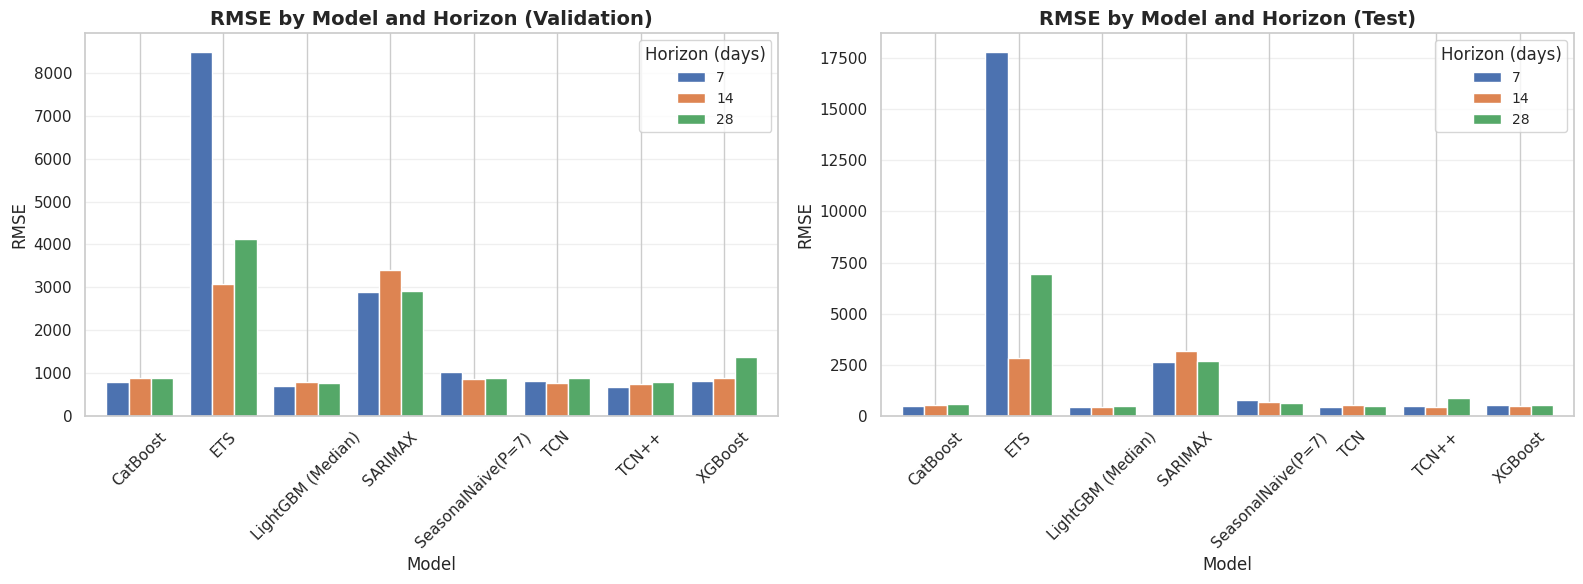

✓ Saved: mase_comparison.png

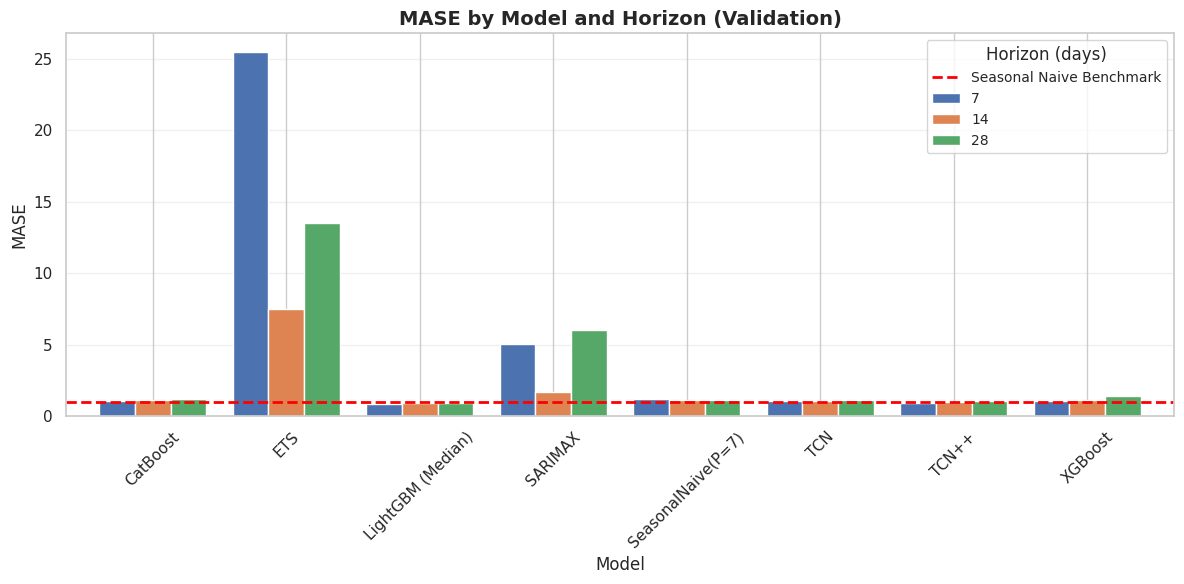

✓ Saved: coverage_comparison.png

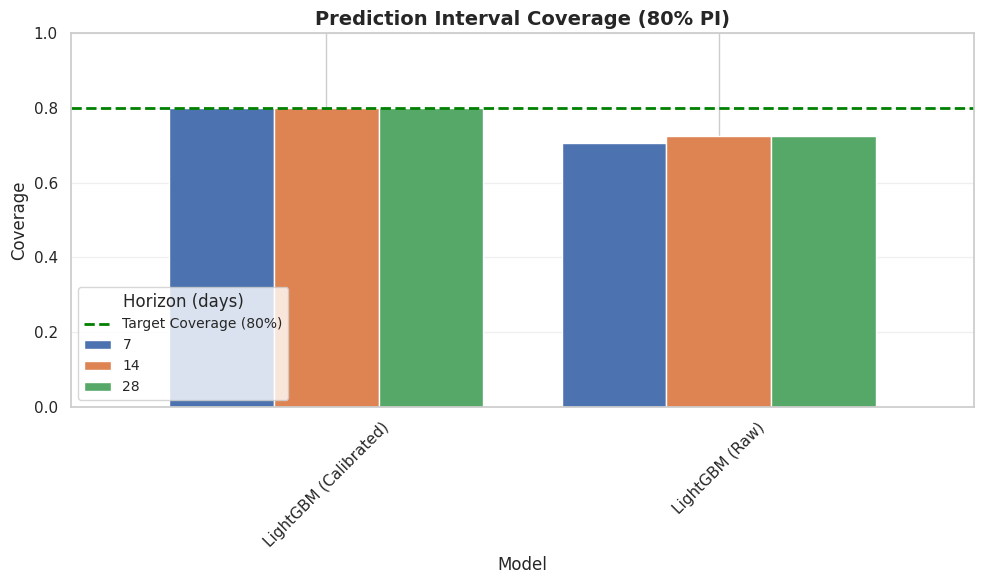

✓ Saved: performance_heatmap.png

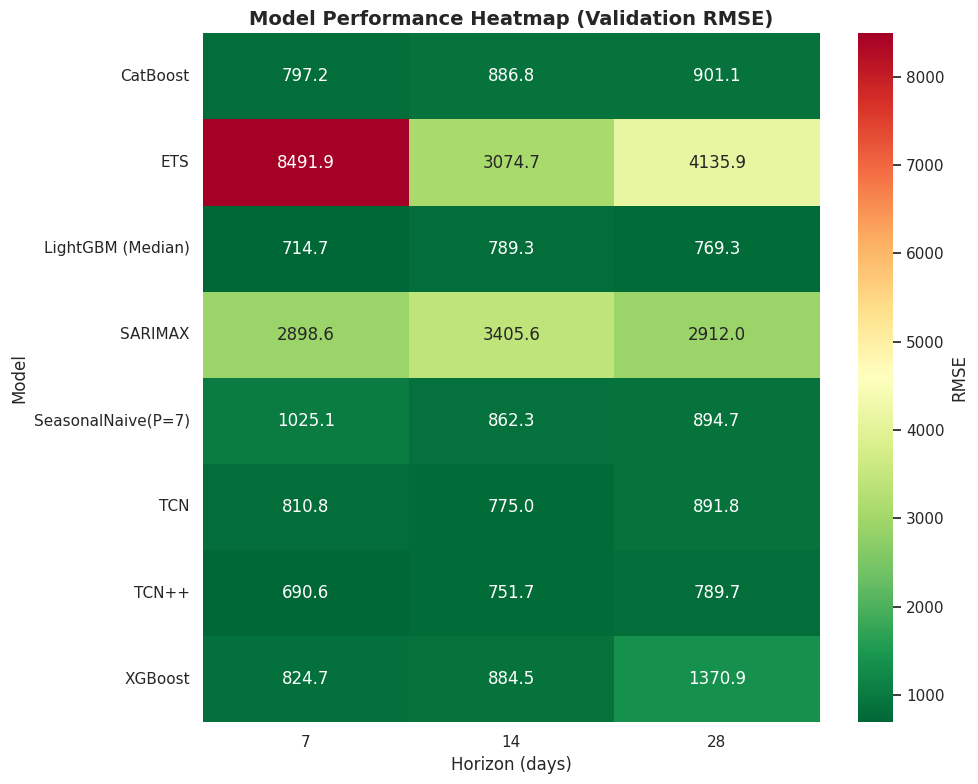

In [52]:
# ============================================================================

rprint("\n[bold cyan]" + "="*80 + "[/bold cyan]")
rprint("[bold cyan]9. Generating Visualizations[/bold cyan]")
rprint("[bold cyan]" + "="*80 + "[/bold cyan]")

# 1. RMSE Comparison Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Validation
val_pivot = val_point.pivot_table(index='model', columns='horizon', values='RMSE')
val_pivot.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('RMSE by Model and Horizon (Validation)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].legend(title='Horizon (days)', fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Test
test_pivot = test_point.pivot_table(index='model', columns='horizon', values='RMSE')
test_pivot.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('RMSE by Model and Horizon (Test)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].legend(title='Horizon (days)', fontsize=10)
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'rmse_comparison.png', dpi=150, bbox_inches='tight')
rprint("  ✓ Saved: rmse_comparison.png")
plt.show()

# 2. MASE Comparison (Validation)
fig, ax = plt.subplots(figsize=(12, 6))
mase_pivot = val_point.pivot_table(index='model', columns='horizon', values='MASE')
mase_pivot.plot(kind='bar', ax=ax, width=0.8)
ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Seasonal Naive Benchmark')
ax.set_title('MASE by Model and Horizon (Validation)', fontsize=14, fontweight='bold')
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('MASE', fontsize=12)
ax.legend(title='Horizon (days)', fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'mase_comparison.png', dpi=150, bbox_inches='tight')
rprint("  ✓ Saved: mase_comparison.png")
plt.show()

# 3. Interval Coverage (if available)
if len(interval_metrics_df) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    coverage_pivot = interval_metrics_df[interval_metrics_df['split'] == 'validation'].pivot_table(
        index='model', columns='horizon', values='Coverage_80%'
    )
    coverage_pivot.plot(kind='bar', ax=ax, width=0.8)
    ax.axhline(y=0.8, color='green', linestyle='--', linewidth=2, label='Target Coverage (80%)')
    ax.set_title('Prediction Interval Coverage (80% PI)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Coverage', fontsize=12)
    ax.set_ylim([0, 1])
    ax.legend(title='Horizon (days)', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'coverage_comparison.png', dpi=150, bbox_inches='tight')
    rprint("  ✓ Saved: coverage_comparison.png")
    plt.show()

# 4. Model Performance Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
heatmap_data = val_point.pivot_table(index='model', columns='horizon', values='RMSE')
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax, cbar_kws={'label': 'RMSE'})
ax.set_title('Model Performance Heatmap (Validation RMSE)', fontsize=14, fontweight='bold')
ax.set_xlabel('Horizon (days)', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'performance_heatmap.png', dpi=150, bbox_inches='tight')
rprint("  ✓ Saved: performance_heatmap.png")
plt.show()

# ============================================================================

✓ Saved: feature_importance.png

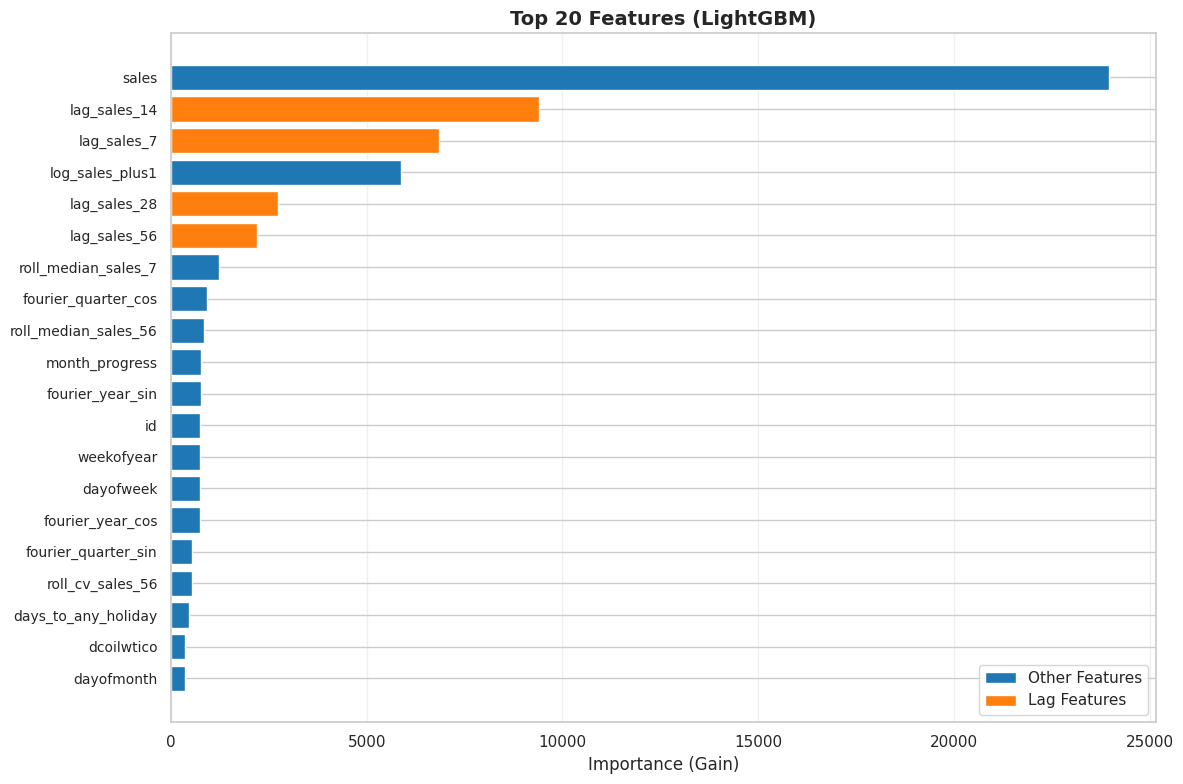

✓ Saved: feature_categories.png

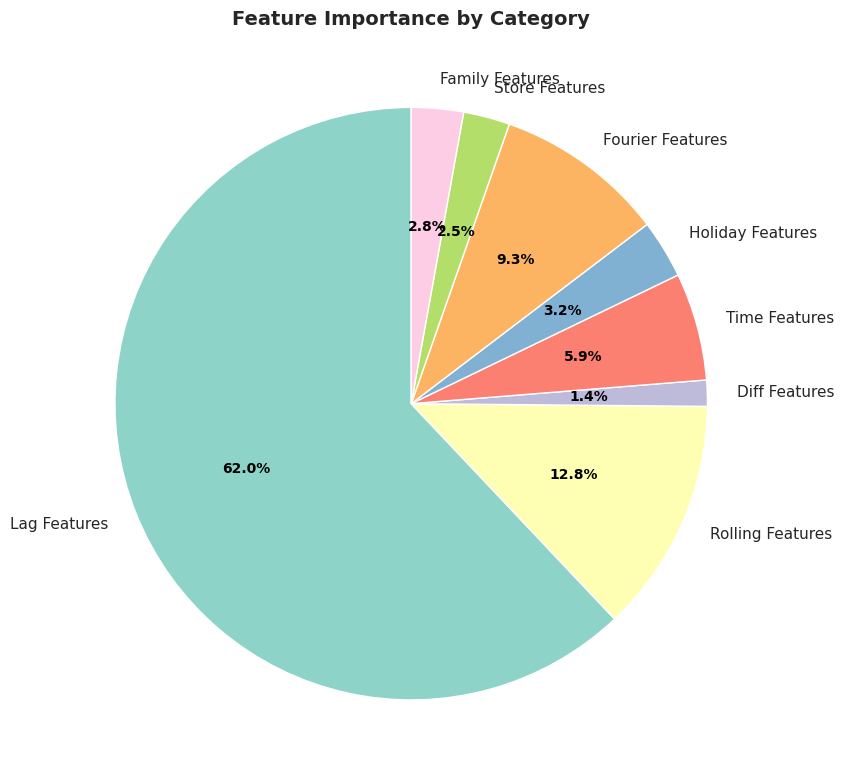

In [53]:
# ============================================================================

if 'importance' in locals() and len(importance) > 0:
    # Top 20 features bar chart
    fig, ax = plt.subplots(figsize=(12, 8))
    top20 = importance.head(20).copy()
    top20 = top20.sort_values('importance')

    colors = ['#1f77b4' if not f.startswith('lag_') else '#ff7f0e' for f in top20['feature']]
    ax.barh(range(len(top20)), top20['importance'], color=colors)
    ax.set_yticks(range(len(top20)))
    ax.set_yticklabels(top20['feature'], fontsize=10)
    ax.set_xlabel('Importance (Gain)', fontsize=12)
    ax.set_title('Top 20 Features (LightGBM)', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#1f77b4', label='Other Features'),
        Patch(facecolor='#ff7f0e', label='Lag Features')
    ]
    ax.legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'feature_importance.png', dpi=150, bbox_inches='tight')
    rprint("  ✓ Saved: feature_importance.png")
    plt.show()

    # Feature category pie chart
    category_importance = {}
    for category, features in feature_categories.items():
        category_features = [f for f in features if f in feature_cols]
        if category_features:
            total_imp = importance[importance['feature'].isin(category_features)]['importance'].sum()
            category_importance[category] = total_imp

    fig, ax = plt.subplots(figsize=(10, 8))
    categories = list(category_importance.keys())
    values = list(category_importance.values())

    colors_palette = sns.color_palette('Set3', len(categories))
    wedges, texts, autotexts = ax.pie(
        values, labels=categories, autopct='%1.1f%%',
        colors=colors_palette, startangle=90
    )

    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)

    ax.set_title('Feature Importance by Category', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'feature_categories.png', dpi=150, bbox_inches='tight')
    rprint("  ✓ Saved: feature_categories.png")
    plt.show()

# ============================================================================

✓ Saved: predictions_store1_GROCERY I.png

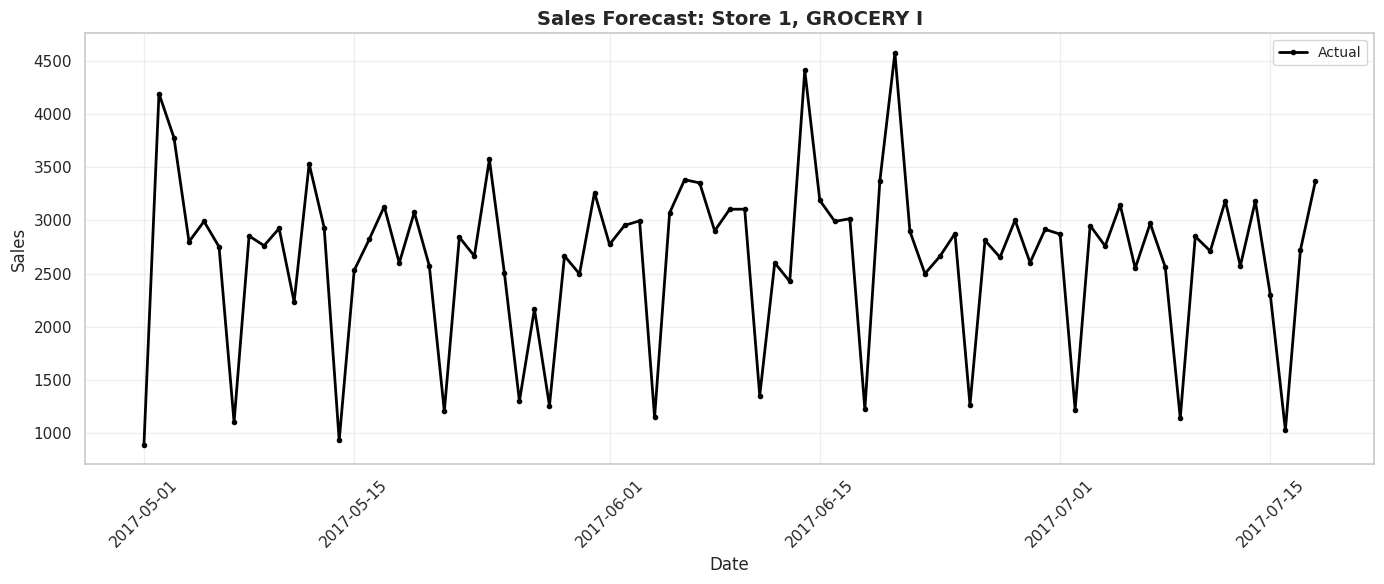

In [54]:
# ============================================================================

# Plot predictions vs actual for a sample store-family
sample_store = TARGET_STORES[0]
sample_family = TARGET_FAMILIES[0]

sample_data = test_df[
    (test_df['store_nbr'] == sample_store) &
    (test_df['family'] == sample_family)
].copy()

if len(sample_data) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))

    # Plot actual
    ax.plot(sample_data['date'], sample_data['sales'],
            label='Actual', linewidth=2, color='black', marker='o', markersize=3)

    # Get predictions for this sample (reconstruct from trained models)
    # For demonstration, we'll plot the trend only
    ax.set_title(f'Sales Forecast: Store {sample_store}, {sample_family}',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Sales', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f'predictions_store{sample_store}_{sample_family}.png',
                dpi=150, bbox_inches='tight')
    rprint(f"  ✓ Saved: predictions_store{sample_store}_{sample_family}.png")
    plt.show()

# ============================================================================

✓ Saved: residual_analysis.png

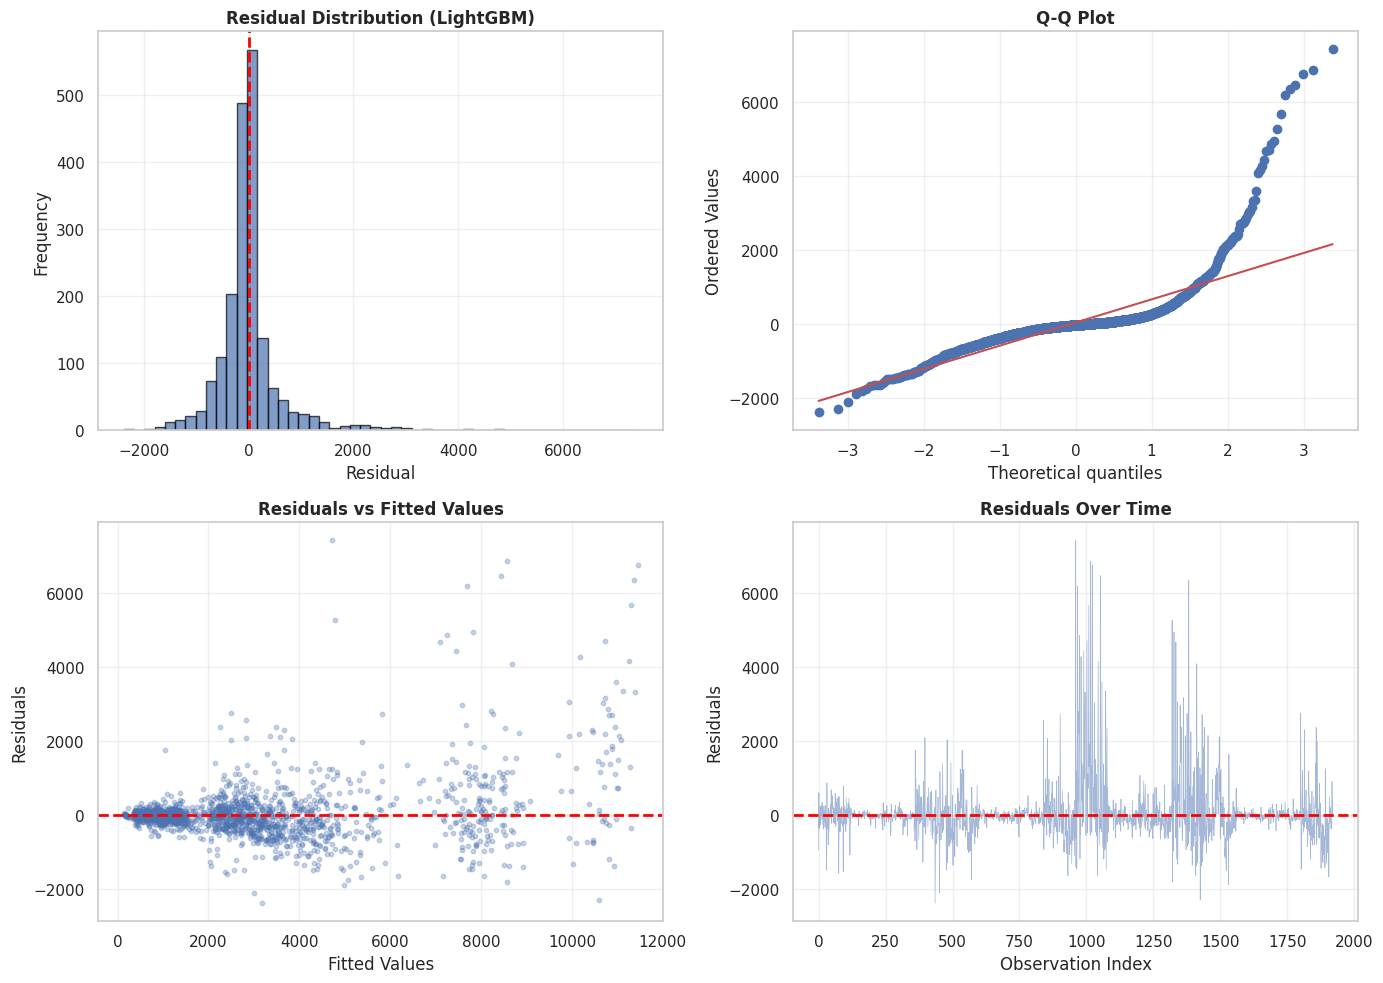

✓ All visualizations generated!

In [55]:
# ============================================================================

# Compute residuals for best model (LightGBM)
# Use last horizon's predictions
if 'y_val' in locals() and 'lgb_val_q50' in locals():
    residuals = y_val - lgb_val_q50

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Residual histogram
    axes[0, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[0, 0].set_title('Residual Distribution (LightGBM)', fontweight='bold')
    axes[0, 0].set_xlabel('Residual')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(alpha=0.3)

    # 2. Q-Q plot
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('Q-Q Plot', fontweight='bold')
    axes[0, 1].grid(alpha=0.3)

    # 3. Residuals vs Fitted
    axes[1, 0].scatter(lgb_val_q50, residuals, alpha=0.3, s=10)
    axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 0].set_title('Residuals vs Fitted Values', fontweight='bold')
    axes[1, 0].set_xlabel('Fitted Values')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].grid(alpha=0.3)

    # 4. Residuals over time
    axes[1, 1].plot(range(len(residuals)), residuals, alpha=0.5, linewidth=0.5)
    axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 1].set_title('Residuals Over Time', fontweight='bold')
    axes[1, 1].set_xlabel('Observation Index')
    axes[1, 1].set_ylabel('Residuals')
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'residual_analysis.png', dpi=150, bbox_inches='tight')
    rprint("  ✓ Saved: residual_analysis.png")
    plt.show()

rprint("\n[bold green]✓ All visualizations generated![/bold green]")

Generating Family-wise metrics from residuals...
  - Calculating scaling factors for MASE...
  ✓ Saved: family_rmse_heatmap.png


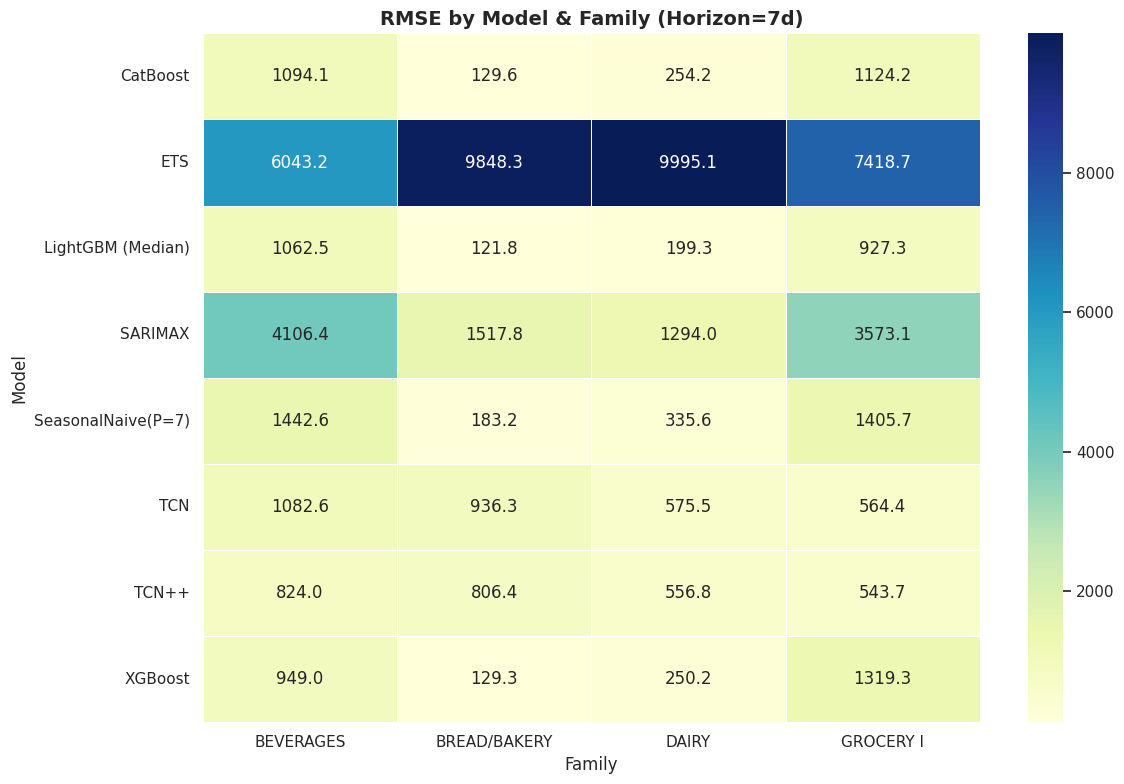

  ✓ Saved: family_mase_heatmap.png


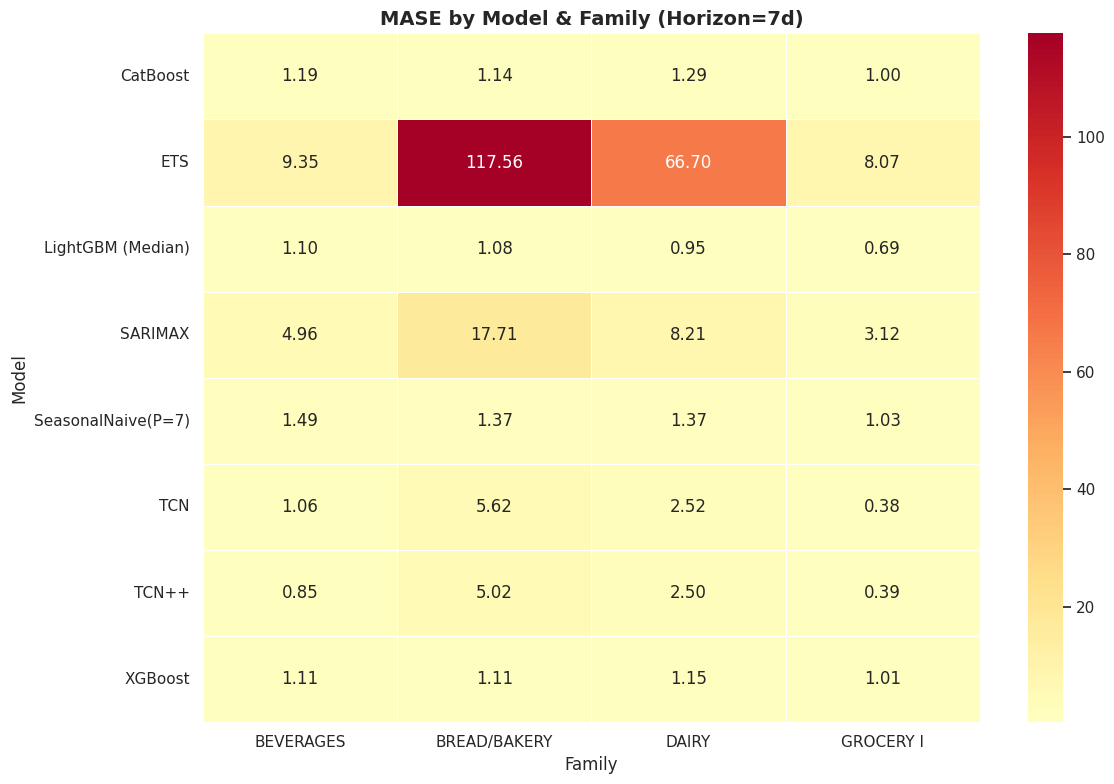

In [60]:
# ============================================================================
# [NEW CELL] Generate Family-wise Heatmaps & Metrics (English)
# ============================================================================
import seaborn as sns
import matplotlib.pyplot as plt

def generate_family_analysis(residual_store, val_df, train_df, target_col_base="target_tplus_"):
    """
    Reverse-engineer Family-wise RMSE and MASE using 'residual_store' and raw data.
    """
    print("Generating Family-wise metrics from residuals...")

    family_metrics_list = []

    # Calculate Naive Error on Training Set (Denominator for MASE)
    print("  - Calculating scaling factors for MASE...")
    scaling_factors = {}
    for family in val_df['family'].unique():
        # Get training series for this family
        train_series = train_df[train_df['family'] == family]['sales'].values

        # Calculate MAE of seasonal difference (m=7)
        if len(train_series) > 7:
            naive_errors = np.abs(train_series[7:] - train_series[:-7])
            scaling_factors[family] = np.mean(naive_errors)
        else:
            scaling_factors[family] = 1.0 # Fallback

    # Iterate through all models and horizons in residual_store
    for model_name, horizons_data in residual_store.items():
        for horizon, splits_data in horizons_data.items():
            if 'validation' not in splits_data: continue

            # Get residuals (y_true - y_pred)
            residuals = splits_data['validation']

            # Create a working copy of validation dataframe
            current_val_df = val_df.copy()

            # Ensure length alignment
            # (Some models like TCN might have fewer predictions due to windowing)
            if len(residuals) != len(current_val_df):
                # Align to the end (assuming chronological order)
                diff = len(current_val_df) - len(residuals)
                if diff > 0:
                    current_val_df = current_val_df.iloc[diff:]
                elif diff < 0:
                     # Handle rare edge cases where residuals are longer
                     residuals = residuals[-len(current_val_df):]

            # Append residuals to dataframe
            current_val_df['resid'] = residuals
            current_val_df['abs_resid'] = np.abs(residuals)
            current_val_df['sq_resid'] = residuals ** 2

            # Aggregate by Family
            fam_groups = current_val_df.groupby('family')

            for family, group in fam_groups:
                rmse = np.sqrt(group['sq_resid'].mean())
                mae = group['abs_resid'].mean()

                # Calculate MASE
                scale = scaling_factors.get(family, 1.0)
                mase = mae / scale if scale != 0 else np.nan

                family_metrics_list.append({
                    'Model': model_name,
                    'Horizon': horizon,
                    'Family': family,
                    'RMSE': rmse,
                    'MASE': mase
                })

    return pd.DataFrame(family_metrics_list)

# 1. Calculate Metrics
if 'residual_store' in locals() and len(residual_store) > 0:
    fam_metrics_df = generate_family_analysis(residual_store, val_df, train_df)

    # 2. Plot Heatmaps for Horizon=7 (Most common for short-term analysis)
    target_h = 7
    subset = fam_metrics_df[fam_metrics_df['Horizon'] == target_h]

    if len(subset) > 0:
        # A. RMSE Heatmap
        plt.figure(figsize=(12, 8))
        rmse_pivot = subset.pivot(index='Model', columns='Family', values='RMSE')
        sns.heatmap(rmse_pivot, annot=True, fmt='.1f', cmap='YlGnBu', linewidths=.5)
        plt.title(f'RMSE by Model & Family (Horizon={target_h}d)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'family_rmse_heatmap.png', dpi=150)
        print("  ✓ Saved: family_rmse_heatmap.png")
        plt.show()

        # B. MASE Heatmap
        plt.figure(figsize=(12, 8))
        mase_pivot = subset.pivot(index='Model', columns='Family', values='MASE')
        # Green (<1) indicates better than naive, Red (>1) indicates worse
        sns.heatmap(mase_pivot, annot=True, fmt='.2f', cmap='RdYlGn_r', center=1.0, linewidths=.5)
        plt.title(f'MASE by Model & Family (Horizon={target_h}d)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'family_mase_heatmap.png', dpi=150)
        print("  ✓ Saved: family_mase_heatmap.png")
        plt.show()

else:
    print("❌ residual_store is empty. Did you run Part 4?")

  ✓ Saved improved plot: results/model_comparison_log.png


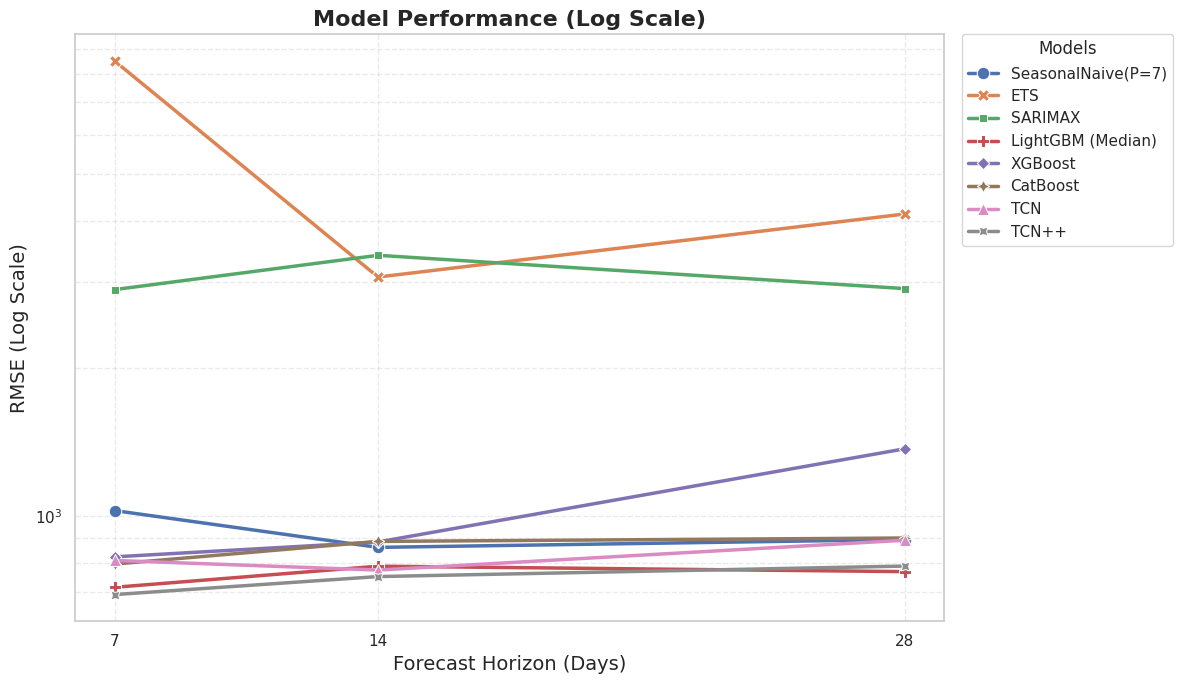

  ✓ Saved improved plot: results/model_comparison_zoomed.png
    (Excluded outliers: ['ETS', 'SARIMAX'])


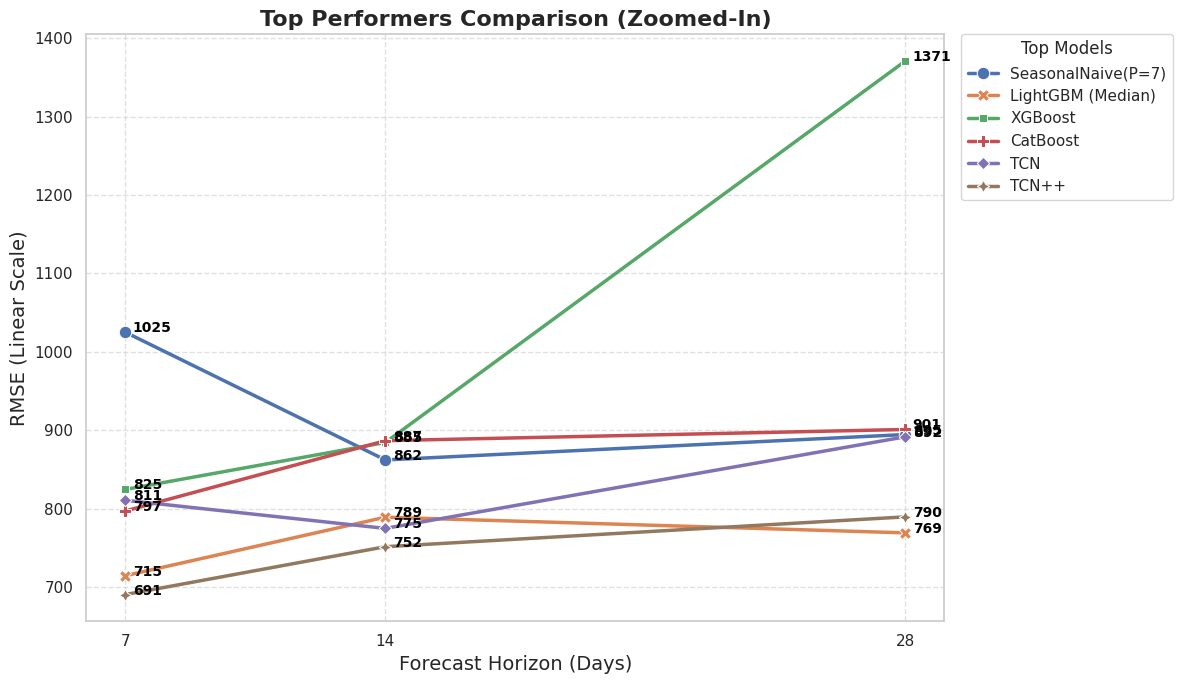

In [61]:
# ============================================================================
# [NEW CELL] Improved Visualizations: Log-Scale & Zoomed-In Curves (English)
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_improved_curves(metrics_df):
    if metrics_df is None or metrics_df.empty:
        print("❌ point_metrics_df is empty. Cannot plot.")
        return

    # Filter for Validation set only
    df_plot = metrics_df[metrics_df['split'] == 'validation'].copy()

    # -------------------------------------------------------
    # Plot 1: Log-Scale Overview
    # -------------------------------------------------------
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=df_plot, x='horizon', y='RMSE', hue='model', style='model',
                 markers=True, dashes=False, linewidth=2.5, markersize=9)

    # Use Log Scale to visualize both high-error and low-error models clearly
    plt.yscale('log')

    plt.title('Model Performance (Log Scale)', fontsize=16, fontweight='bold')
    plt.xlabel('Forecast Horizon (Days)', fontsize=14)
    plt.ylabel('RMSE (Log Scale)', fontsize=14)
    plt.grid(True, which="both", ls="--", alpha=0.4)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title="Models")
    plt.xticks(sorted(df_plot['horizon'].unique()))
    plt.tight_layout()

    save_path_log = OUTPUT_DIR / 'model_comparison_log.png'
    plt.savefig(save_path_log, dpi=150)
    print(f"  ✓ Saved improved plot: {save_path_log}")
    plt.show()

    # -------------------------------------------------------
    # Plot 2: Top Performers Comparison (Zoomed-In)
    # -------------------------------------------------------
    # Filter out poor performing models (e.g., RMSE > 1500 like ETS/SARIMAX)
    bad_models = df_plot[df_plot['RMSE'] > 1500]['model'].unique()
    df_zoomed = df_plot[~df_plot['model'].isin(bad_models)].copy()

    if not df_zoomed.empty:
        plt.figure(figsize=(12, 7))
        sns.lineplot(data=df_zoomed, x='horizon', y='RMSE', hue='model', style='model',
                     markers=True, dashes=False, linewidth=2.5, markersize=9)

        plt.title('Top Performers Comparison (Zoomed-In)', fontsize=16, fontweight='bold')
        plt.xlabel('Forecast Horizon (Days)', fontsize=14)
        plt.ylabel('RMSE (Linear Scale)', fontsize=14)

        # Add data labels for clarity
        for line in range(0, df_zoomed.shape[0]):
             plt.text(df_zoomed.horizon.iloc[line]+0.2,
                      df_zoomed.RMSE.iloc[line],
                      f"{df_zoomed.RMSE.iloc[line]:.0f}",
                      horizontalalignment='left',
                      size='small',
                      color='black',
                      weight='semibold')

        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title="Top Models")
        plt.xticks(sorted(df_zoomed['horizon'].unique()))
        plt.tight_layout()

        save_path_zoom = OUTPUT_DIR / 'model_comparison_zoomed.png'
        plt.savefig(save_path_zoom, dpi=150)
        print(f"  ✓ Saved improved plot: {save_path_zoom}")
        print(f"    (Excluded outliers: {list(bad_models)})")
        plt.show()
    else:
        print("⚠️ No models left after filtering outliers.")

# Execute Plotting
if 'point_metrics_df' in locals():
    plot_improved_curves(point_metrics_df)
else:
    # Try to reconstruct point_metrics_df from all_results if necessary
    if 'all_results' in locals() and len(all_results['point_metrics']) > 0:
        point_metrics_df = pd.DataFrame(all_results['point_metrics'])
        plot_improved_curves(point_metrics_df)
    else:
        print("❌ Data not found. Please run Part 4 first.")

In [62]:
# ============================================================================

rprint("\n" + "="*80)
rprint("[bold cyan]" + " "*20 + "FINAL SUMMARY REPORT" + " "*20 + "[/bold cyan]")
rprint("="*80 + "\n")

# Executive Summary
rprint("[bold]📊 EXECUTIVE SUMMARY[/bold]")
rprint("-" * 80)

# Dataset info
rprint(f"\n[bold]Dataset:[/bold]")
rprint(f"  • Stores: {len(TARGET_STORES)}")
rprint(f"  • Product Families: {len(TARGET_FAMILIES)}")
rprint(f"  • Train Period: {train_df['date'].min()} to {train_df['date'].max()}")
rprint(f"  • Validation Period: {val_df['date'].min()} to {val_df['date'].max()}")
rprint(f"  • Test Period: {test_df['date'].min()} to {test_df['date'].max()}")
rprint(f"  • Total Observations: {len(feature_df):,}")
rprint(f"  • Features Engineered: {len(feature_cols)}")

# Models trained
rprint(f"\n[bold]Models Trained:[/bold]")
models_list = point_metrics_df['model'].unique()
for i, model in enumerate(models_list, 1):
    model_type = ""
    if model in ['SeasonalNaive(P=7)']:
        model_type = "(Baseline)"
    elif model in ['ETS', 'SARIMAX']:
        model_type = "(Classical)"
    elif model in ['LightGBM (Median)', 'XGBoost', 'CatBoost']:
        model_type = "(Gradient Boosting)"
    elif model == 'TCN':
        model_type = "(Deep Learning)"

    rprint(f"  {i}. {model} {model_type}")

# Horizons
rprint(f"\n[bold]Forecast Horizons:[/bold]")
for h in HORIZONS:
    rprint(f"  • {h} days")

# Evaluation metrics
rprint(f"\n[bold]Evaluation Metrics:[/bold]")
rprint("  Point Metrics:")
rprint("    - RMSE: Root Mean Squared Error")
rprint("    - MAE: Mean Absolute Error")
rprint("    - sMAPE: Symmetric Mean Absolute Percentage Error")
rprint("    - MASE: Mean Absolute Scaled Error (< 1.0 = better than Seasonal Naive)")
rprint("  Probabilistic Metrics:")
rprint("    - Pinball Loss: Quantile regression accuracy")
rprint("    - Coverage: Prediction interval calibration")
rprint("    - CRPS: Continuous Ranked Probability Score")
rprint("  Statistical Tests:")
rprint("    - Diebold-Mariano: Forecast accuracy comparison")

# ============================================================================

================================================================================

                    FINAL SUMMARY REPORT                    

================================================================================

📊 EXECUTIVE SUMMARY

--------------------------------------------------------------------------------

Dataset:

• Stores: 4

• Product Families: 5

• Train Period: 2013-02-26 00:00:00 to 2016-12-31 00:00:00

• Validation Period: 2017-01-01 00:00:00 to 2017-04-30 00:00:00

• Test Period: 2017-05-01 00:00:00 to 2017-07-18 00:00:00

• Total Observations: 25,600

• Features Engineered: 98

Models Trained:

1. SeasonalNaive(P=7) (Baseline)

2. ETS (Classical)

3. SARIMAX (Classical)

4. LightGBM (Median) (Gradient Boosting)

5. XGBoost (Gradient Boosting)

6. CatBoost (Gradient Boosting)

7. TCN (Deep Learning)

8. TCN++

Forecast Horizons:

• 7 days

• 14 days

• 28 days

Evaluation Metrics:

Point Metrics:

- RMSE: Root Mean Squared Error

- MAE: Mean Absolute Error

- sMAPE: Symmetric Mean Absolute Percentage Error

- MASE: Mean Absolute Scaled Error (< 1.0 = better than Seasonal Naive)

Probabilistic Metrics:

- Pinball Loss: Quantile regression accuracy

- Coverage: Prediction interval calibration

- CRPS: Continuous Ranked Probability Score

Statistical Tests:

- Diebold-Mariano: Forecast accuracy comparison

In [63]:
# ============================================================================

rprint("\n" + "="*80)
rprint("[bold]🏆 BEST PERFORMING MODELS[/bold]")
rprint("="*80 + "\n")

# Best by RMSE (Validation)
rprint("[bold]Best Models by RMSE (Validation):[/bold]")
for h in HORIZONS:
    horizon_data = val_point[val_point['horizon'] == h].copy()
    if len(horizon_data) > 0:
        best_idx = horizon_data['RMSE'].idxmin()
        best = horizon_data.loc[best_idx]

        # Compare to baseline
        baseline = horizon_data[horizon_data['model'] == 'SeasonalNaive(P=7)']
        if len(baseline) > 0:
            baseline_rmse = baseline.iloc[0]['RMSE']
            improvement = ((baseline_rmse - best['RMSE']) / baseline_rmse) * 100
            rprint(f"\n  Horizon {h} days:")
            rprint(f"    Model: {best['model']}")
            rprint(f"    RMSE: {best['RMSE']:.2f}")
            rprint(f"    MAE: {best['MAE']:.2f}")
            rprint(f"    MASE: {best['MASE']:.3f}")
            rprint(f"    sMAPE: {best['sMAPE (%)']:.2f}%")
            rprint(f"    Improvement over Naive: {improvement:.1f}%")

# Best by RMSE (Test)
rprint("\n[bold]Best Models by RMSE (Test):[/bold]")
for h in HORIZONS:
    horizon_data = test_point[test_point['horizon'] == h].copy()
    if len(horizon_data) > 0:
        best_idx = horizon_data['RMSE'].idxmin()
        best = horizon_data.loc[best_idx]

        baseline = horizon_data[horizon_data['model'] == 'SeasonalNaive(P=7)']
        if len(baseline) > 0:
            baseline_rmse = baseline.iloc[0]['RMSE']
            improvement = ((baseline_rmse - best['RMSE']) / baseline_rmse) * 100
            rprint(f"\n  Horizon {h} days:")
            rprint(f"    Model: {best['model']}")
            rprint(f"    RMSE: {best['RMSE']:.2f}")
            rprint(f"    MAE: {best['MAE']:.2f}")
            rprint(f"    MASE: {best['MASE']:.3f}")
            rprint(f"    sMAPE: {best['sMAPE (%)']:.2f}%")
            rprint(f"    Improvement over Naive: {improvement:.1f}%")

# ============================================================================

================================================================================

🏆 BEST PERFORMING MODELS

================================================================================

Best Models by RMSE (Validation):

Horizon 7 days:

Model: TCN++

RMSE: 690.63

MAE: 375.92

MASE: 0.947

sMAPE: nan%

Improvement over Naive: 32.6%

Horizon 14 days:

Model: TCN++

RMSE: 751.66

MAE: 399.22

MASE: 0.993

sMAPE: nan%

Improvement over Naive: 12.8%

Horizon 28 days:

Model: LightGBM (Median)

RMSE: 769.31

MAE: 383.39

MASE: 0.952

sMAPE: 13.29%

Improvement over Naive: 14.0%

Best Models by RMSE (Test):

Horizon 7 days:

Model: LightGBM (Median)

RMSE: 454.11

MAE: 238.18

MASE: 0.600

sMAPE: 9.16%

Improvement over Naive: 41.6%

Horizon 14 days:

Model: LightGBM (Median)

RMSE: 464.38

MAE: 230.79

MASE: 0.574

sMAPE: 8.64%

Improvement over Naive: 32.9%

Horizon 28 days:

Model: TCN

RMSE: 509.30

MAE: 303.94

MASE: 0.755

sMAPE: 13.17%

Improvement over Naive: 21.5%

In [64]:
# ============================================================================

rprint("\n" + "="*80)
rprint("[bold]🔍 KEY FINDINGS AND INSIGHTS[/bold]")
rprint("="*80 + "\n")

# 1. Model Performance Ranking
rprint("[bold]1. Model Performance Ranking (Average RMSE across all horizons):[/bold]")
avg_rmse = val_point.groupby('model')['RMSE'].mean().sort_values()
for rank, (model, rmse_val) in enumerate(avg_rmse.items(), 1):
    rprint(f"   {rank}. {model:25s}: {rmse_val:.2f}")

# 2. MASE Analysis
rprint("\n[bold]2. MASE Analysis (Models better than Seasonal Naive):[/bold]")
avg_mase = val_point.groupby('model')['MASE'].mean().sort_values()
better_than_naive = avg_mase[avg_mase < 1.0]
if len(better_than_naive) > 0:
    for model, mase_val in better_than_naive.items():
        improvement = (1.0 - mase_val) * 100
        rprint(f"   ✅ {model:25s}: MASE = {mase_val:.3f} ({improvement:.1f}% better)")
else:
    rprint("   ⚠️ No models consistently beat Seasonal Naive across all horizons")

worse_than_naive = avg_mase[avg_mase >= 1.0]
if len(worse_than_naive) > 0:
    rprint("\n   Models not beating Seasonal Naive:")
    for model, mase_val in worse_than_naive.items():
        rprint(f"   ❌ {model:25s}: MASE = {mase_val:.3f}")

# 3. Statistical Significance
if len(dm_df) > 0:
    rprint("\n[bold]3. Statistical Significance (Diebold-Mariano Tests):[/bold]")
    significant = dm_df[dm_df['p_value'].astype(float) < 0.05]
    if len(significant) > 0:
        rprint(f"   Found {len(significant)} significant differences (p < 0.05):")
        for _, row in significant.iterrows():
            rprint(f"   • H={row['horizon']}d: {row['winner']} (p={row['p_value']})")
    else:
        rprint("   ⚠️ No statistically significant differences detected at p < 0.05")

# 4. Interval Calibration
if len(interval_metrics_df) > 0:
    rprint("\n[bold]4. Prediction Interval Calibration (80% PI):[/bold]")
    val_intervals = interval_metrics_df[interval_metrics_df['split'] == 'validation']
    avg_coverage = val_intervals.groupby('model')['Coverage_80%'].mean().sort_values(ascending=False)
    for model, cov in avg_coverage.items():
        status = "✅ Well-calibrated" if abs(cov - 0.8) < 0.05 else "⚠️ Needs calibration"
        rprint(f"   {model:25s}: {cov:.2%} coverage {status}")

# ============================================================================

================================================================================

🔍 KEY FINDINGS AND INSIGHTS

================================================================================

1. Model Performance Ranking (Average RMSE across all horizons):

1. TCN++                    : 743.99

2. LightGBM (Median)        : 757.77

3. TCN                      : 825.86

4. CatBoost                 : 861.73

5. SeasonalNaive(P=7)       : 927.35

6. XGBoost                  : 1026.70

7. SARIMAX                  : 3072.08

8. ETS                      : 5234.14

2. MASE Analysis (Models better than Seasonal Naive):

✅ LightGBM (Median)        : MASE = 0.911 (8.9% better)

Models not beating Seasonal Naive:

❌ TCN++                    : MASE = 1.006

❌ TCN                      : MASE = 1.068

❌ CatBoost                 : MASE = 1.145

❌ SeasonalNaive(P=7)       : MASE = 1.156

❌ XGBoost                  : MASE = 1.193

❌ SARIMAX                  : MASE = 4.239

❌ ETS                      : MASE = 15.505

3. Statistical Significance (Diebold-Mariano Tests):

Found 11 significant differences (p < 0.05):

• H=7d: LightGBM (Median) (p=0.0005)

• H=7d: LightGBM (Median) (p=0.0000)

• H=7d: LightGBM (Median) (p=0.0464)

• H=7d: LightGBM (Median) (p=0.0021)

• H=7d: SARIMAX (p=0.0000)

• H=14d: LightGBM (Median) (p=0.0000)

• H=14d: LightGBM (Median) (p=0.0000)

• H=14d: ETS (p=0.0472)

• H=28d: LightGBM (Median) (p=0.0000)

• H=28d: LightGBM (Median) (p=0.0012)

• H=28d: SARIMAX (p=0.0001)

4. Prediction Interval Calibration (80% PI):

LightGBM (Calibrated)    : 80.10% coverage ✅ Well-calibrated

LightGBM (Raw)           : 71.91% coverage ⚠️ Needs calibration

In [65]:
# ============================================================================
# [NEW CELL] Compress and Download Results
# ============================================================================
import os
from google.colab import files

print("Compressing results folder...")
!zip -r results.zip results/

print("Downloading results.zip...")
try:
    files.download('results.zip')
except Exception as e:
    print(f"Download failed: {e}")
    print("You can manually download 'results.zip' from the file browser on the left.")

Compressing results folder...
updating: results/ (stored 0%)
updating: results/rmse_comparison.png (deflated 18%)
updating: results/mase_comparison.png (deflated 19%)
updating: results/point_metrics.csv (deflated 51%)
updating: results/feature_categories.png (deflated 8%)
updating: results/dm_tests.csv (deflated 74%)
updating: results/feature_importance.png (deflated 26%)
updating: results/coverage_comparison.png (deflated 16%)
updating: results/dm_tests_real.csv (deflated 74%)
updating: results/performance_heatmap.png (deflated 13%)
updating: results/predictions_store1_GROCERY I.png (deflated 11%)
updating: results/interval_metrics.csv (deflated 59%)
updating: results/residual_analysis.png (deflated 9%)
  adding: results/family_mase_heatmap.png (deflated 17%)
  adding: results/model_comparison_zoomed.png (deflated 9%)
  adding: results/family_rmse_heatmap.png (deflated 13%)
  adding: results/model_comparison_log.png (deflated 11%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>